##**What does your watch history tell you?**
Fall 2024 Data Science Project

Clara Gong

##**Introduction**

I, like many other people have spent a lot of time consuming media. Whether it is through shortform video or longer shows or movies, these media sources serve to influence the public. Youtube stands at the front of video creation and consumption as it offers a variety of content. From educational tutorials to livestreams and mockumentaries, Youtube serves as a source of entertainment, education, and more.

This project walks through the major steps of data analysis, applying the concepts to a fun topic. Youtube captures and provides a lot of data on the videos that it hosts. Using this data we can discover trends in a person's preferences and watch history.

While this may seem trivial, it can actually be very useful. For companies they might be interested in seeing how video metrics affect sales. On a more individual level, you can learn a lot more about your own habits. For example: What types of content do I seem to watch more, and how do my preferences change over time? Other good questions to consider are the frequency or occasion in which you watch Youtube or if there are relationships between video characteristics and your own engagement.

These are all guiding questions and considerations we can use throughout this project to learn more about ourselves.

##**Data Curation**
All of the data that I will be using is sourced from my own Youtube watch history starting from 2018 and continuing well into 2024. Due to privacy and other concerns it is a bit harder to scrape user data directly. As such this data was collected using a combination of Google Takeout (https://takeout.google.com/) and Google's Youtube API (https://developers.google.com/youtube/v3).

The first step in collecting data was to download my watch history in JSON form using Google Takeout. This format is a bit hard to analyze by itself so using some Python we will transform it into a CSV file. This was done using the following:


In [ ]:
import json
import csv

# For processing json watch history into a dataset

JSON_FILE = "watch-history.json"
CSV_FILE = "watch-history.csv"

# load in file
with open(JSON_FILE, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract columns data
with open(CSV_FILE, mode='w', newline='', encoding='utf-8') as csv_file:
    # open output file
    fout = csv.writer(csv_file)
    fout.writerow(['Title', 'Video URL', 'Channel', 'Date Watched', 'Ad?'])

    # process each entry
    for item in data:
        title = item.get('title', 'No Title')
        video_url = item.get('titleUrl', 'No URL')
        date = item.get('time', 'No Date')
        ad_status = False

        # Try to get channel, json includes youtube ads so those either
        # have a channel or are N/A
        if 'subtitles' in item:
            channel_name = item['subtitles'][0].get('name', 'N/A')
        else:
            channel_name = 'N/A'

        # further checks for ad status
        if 'details' in item:
            ad_status = True

        # write data row
        fout.writerow([title, video_url, channel_name, date, ad_status])

After transforming the JSON file into a more palatable CSV, we can begin looking at it further.

The first step to doing this: Setup all the necessary libraries


In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats


Next Step: Import the first data set containing all videos in the channel's watch history

In [3]:
#import the first data set of the channel's watch history
df = pd.read_csv("watch-history.csv")
df.head(10)

Title  \
0  Watched https://www.youtube.com/watch?v=ifoa0L...   
1  Watched https://www.youtube.com/watch?v=F-Qc8f...   
2  Watched https://www.youtube.com/watch?v=1Lr8Zu...   
3                     Viewed Ads On YouTube Homepage   
4  Watched https://www.youtube.com/watch?v=c4xEw5...   
5  Watched https://www.youtube.com/watch?v=hCXxAJ...   
6  Watched DAVID ENG H277773 EQUITY EARBUDS US 20...   
7  Watched https://www.youtube.com/watch?v=Ef8vb7...   
8  Watched https://www.youtube.com/watch?v=I8zKFw...   
9  Watched Let's Rank the Leviathans in Subnautic...   

                                     Video URL   Channel  \
0  https://www.youtube.com/watch?v=ifoa0LKZaXo       NaN   
1  https://www.youtube.com/watch?v=F-Qc8fNrbzY       NaN   
2  https://www.youtube.com/watch?v=1Lr8ZuquO-Q       NaN   
3                                       No URL       NaN   
4  https://www.youtube.com/watch?v=c4xEw53CYpQ       NaN   
5  https://www.youtube.com/watch?v=hCXxAJrc-Os       NaN   
6  https://www.youtube.com/watch?v=i2vPSRmgqUo       NaN   
7  https://www.youtube.com/watch?v=Ef8vb7mF8a4       NaN   
8  https://www.youtube.com/watch?v=I8zKFwzpjZU       NaN   
9  https://www.youtube.com/watch?v=BPI0MhG-aqw  Floydson   

               Date Watched    Ad?  
0  2024-10-21T23:36:50.230Z   True  
1  2024-10-21T23:36:45.823Z   True  
2  2024-10-21T23:36:38.805Z   True  
3  2024-10-21T23:36:25.100Z   True  
4  2024-10-21T23:36:21.557Z   True  
5  2024-10-21T23:35:23.987Z  False  
6  2024-10-21T23:35:17.975Z   True  
7  2024-10-21T23:34:10.741Z  False  
8  2024-10-21T23:34:05.141Z  False  
9  2024-10-21T23:33:06.309Z  False

Now we can clean out some of the irrelevant data such as all of the ads that were included in the watch history. Also the dataset includes posts on youtuber community boards. We can drop these entries which start with "viewed" and we can trim out the prepended "Watched" for each of the video titles.

In [4]:
filtered_df = df[df["Ad?"] != True]
filtered_df = filtered_df[~filtered_df["Title"].str.startswith("Viewed ")].reset_index(drop=True)
filtered_df["Title"] = filtered_df["Title"].str.replace("Watched ", "", n=1)

filtered_df

Title  \
0            https://www.youtube.com/watch?v=hCXxAJrc-Os   
1            https://www.youtube.com/watch?v=Ef8vb7mF8a4   
2            https://www.youtube.com/watch?v=I8zKFwzpjZU   
3      Let's Rank the Leviathans in Subnautica: Below...   
4            https://www.youtube.com/watch?v=tREaghvgqiw   
...                                                  ...   
30833        https://www.youtube.com/watch?v=pkjGVzhGEN4   
30834      SPIDER-MAN ROCK CLIMBING DISASTER (Cell Outs)   
30835               LOGAN REAL LIFE TRAINING (Cell Outs)   
30836                  ARCHERY PAINTBALL TAG (Cell Outs)   
30837         TOMAHAWK CHOP IS OUR DEATHBLOW (Cell Outs)   

                                         Video URL      Channel  \
0      https://www.youtube.com/watch?v=hCXxAJrc-Os          NaN   
1      https://www.youtube.com/watch?v=Ef8vb7mF8a4          NaN   
2      https://www.youtube.com/watch?v=I8zKFwzpjZU          NaN   
3      https://www.youtube.com/watch?v=BPI0MhG-aqw     Floydson   
4      https://www.youtube.com/watch?v=tREaghvgqiw          NaN   
...                                            ...          ...   
30833  https://www.youtube.com/watch?v=pkjGVzhGEN4          NaN   
30834  https://www.youtube.com/watch?v=IyAos6ddX5A  Smosh Games   
30835  https://www.youtube.com/watch?v=1nBtDv00GgQ  Smosh Games   
30836  https://www.youtube.com/watch?v=A7g23cQlWtc  Smosh Games   
30837  https://www.youtube.com/watch?v=gfVxlblJReg  Smosh Games   

                   Date Watched    Ad?  
0      2024-10-21T23:35:23.987Z  False  
1      2024-10-21T23:34:10.741Z  False  
2      2024-10-21T23:34:05.141Z  False  
3      2024-10-21T23:33:06.309Z  False  
4      2024-10-21T23:28:53.581Z  False  
...                         ...    ...  
30833  2018-03-27T00:46:59.455Z  False  
30834  2018-03-27T00:38:58.436Z  False  
30835  2018-03-27T00:25:51.738Z  False  
30836  2018-03-27T00:18:44.381Z  False  
30837  2018-03-26T22:54:34.867Z  False  

[30838 rows x 5 columns]

From here I will save this new dataframe into a new CSV file and we can do some additional work to scrape more Youtube data about the videos in order to gather more information. Currently the dataframe has a limited number of columns and it can visually be seen that some fields are not populated correctly.

In [5]:
filtered_df.to_csv("filtered_history.csv")

Now that we have our filtered CSV file we will use Google's Youtube API to search for the given URL and retrieve information like view count, duration, and category. One thing to note is that the process of scraping data took me a few days to complete. The reason for this was that the Youtube API allots a limited number of credits to use per day. The scraping used the following:

In [ ]:
import json
import csv
import re

from googleapiclient.discovery import build
from config import API_KEY

youtube = build('youtube', 'v3', developerKey=API_KEY)

#makes the api call and fetches data categories
def fetch(video):
    request = youtube.videos().list(part="snippet,statistics,contentDetails,topicDetails", id=video)
    response = request.execute()

    if response:
        if response["items"]: #deals with privated or videos that no longer exist TwosetViolin RIP :(
            v = response["items"][0]

            data = {
                "title": v["snippet"]["title"],
                "description": v["snippet"]["description"],
                "channel_name": v["snippet"]["channelTitle"],
                "published_at": v["snippet"]["publishedAt"],
                "category_id": v["snippet"]["categoryId"],
                "view_count": v["statistics"].get("viewCount", "N/A"),
                "like_count": v["statistics"].get("likeCount", "N/A"),
                "comment_count": v["statistics"].get("commentCount", "N/A"),
                "duration": v["contentDetails"]["duration"]
            }

            return data
    return None

#uses category id and decodes into actual category
def fetch_category(category_id):
    request = youtube.videoCategories().list(part="snippet", id=category_id)
    response = request.execute()

    if response["items"]:
        category = response["items"][0]
        return category["snippet"]["title"]
    return "N/A"

#takes in a given csv and fetches additional info to place into output csv
def process(input_csv, output_csv):
    with open(input_csv, 'r', encoding='utf-8') as infile, open(output_csv, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        writer = csv.DictWriter(outfile, fieldnames=["Title", "Video URL", "Channel", "Category", "View Count", "Like Count", "Comment Count", "Duration"])
        writer.writeheader()

        for row in reader:
            url = row["Video URL"]
            match = re.search(r"v=([^&]+)", url)
            if match: #potentially if no url is included in the file
                video_id = match.group(1)

                if video_id:
                    video_details = fetch(video_id)

                    #ensuring that fetch had a result
                    if video_details:
                        category_name = fetch_category(video_details["category_id"])

                        writer.writerow({
                            "Title": video_details["title"],
                            "Video URL": url,
                            "Channel": video_details["channel_name"],
                            "Category": category_name,
                            "View Count": video_details["view_count"],
                            "Like Count": video_details["like_count"],
                            "Comment Count": video_details["comment_count"],
                            "Duration": video_details["duration"]
                        })

process('filtered_history.csv', 'videos6.csv')

Huzzah! Now we have a more detailed videos dataframe that we can examine and use.

In [7]:
videos = pd.read_csv("videos_dataset.csv")
videos

Title  \
0                     Magnus Carlsen: "I'm No Genius’" 😮   
1       The MOST VALUABLE ITEM in Stardew Valley 1.6?! 😱   
2            Michael Wants To Sleep with Poki and Lily??   
3      Let's Rank the Leviathans in Subnautica: Below...   
4      My last two brain cells trying to do this chal...   
...                                                  ...   
28414                    TRAPEZE CIRCUS FAIL (Cell Outs)   
28415      SPIDER-MAN ROCK CLIMBING DISASTER (Cell Outs)   
28416               LOGAN REAL LIFE TRAINING (Cell Outs)   
28417                  ARCHERY PAINTBALL TAG (Cell Outs)   
28418         TOMAHAWK CHOP IS OUR DEATHBLOW (Cell Outs)   

                                         Video URL           Channel  \
0      https://www.youtube.com/watch?v=hCXxAJrc-Os          GJ_Chess   
1      https://www.youtube.com/watch?v=Ef8vb7mF8a4              MRIZ   
2      https://www.youtube.com/watch?v=I8zKFwzpjZU  Offline Network    
3      https://www.youtube.com/watch?v=BPI0MhG-aqw          Floydson   
4      https://www.youtube.com/watch?v=tREaghvgqiw         OfflineTV   
...                                            ...               ...   
28414  https://www.youtube.com/watch?v=pkjGVzhGEN4       Smosh Games   
28415  https://www.youtube.com/watch?v=IyAos6ddX5A       Smosh Games   
28416  https://www.youtube.com/watch?v=1nBtDv00GgQ       Smosh Games   
28417  https://www.youtube.com/watch?v=A7g23cQlWtc       Smosh Games   
28418  https://www.youtube.com/watch?v=gfVxlblJReg       Smosh Games   

              Category  View Count  Like Count  Comment Count  Duration  
0       People & Blogs   1247761.0     57619.0         1469.0     PT51S  
1               Gaming     46724.0      3514.0           28.0      PT1M  
2        Entertainment     20657.0      2211.0           15.0     PT54S  
3               Gaming   2049923.0    126350.0          752.0     PT56S  
4      News & Politics    111920.0      6318.0           46.0     PT34S  
...                ...         ...         ...            ...       ...  
28414           Gaming    493012.0      9738.0          775.0  PT19M44S  
28415           Gaming    297159.0      6968.0          861.0  PT11M17S  
28416           Gaming    460051.0      9020.0          616.0  PT24M26S  
28417           Gaming    390391.0      8607.0          484.0  PT13M27S  
28418           Gaming    517716.0     11595.0         1417.0   PT17M5S  

[28419 rows x 8 columns]

Lets check to see if there are major differences between the videos dataset and the filtered dataset used in generating it. One thing of note is that the videos data set is not the same size as the filtered history data set.

In [8]:
len1 = filtered_df.shape[0]
len2 = videos.shape[0]  #gets number of rows in each dataframe

print(f'Length of filtered_df: {len1}')
print(f'Length of videos: {len2}')

print(f'Difference: {len1-len2}') # the difference in number

Length of filtered_df: 30838
Length of videos: 28419
Difference: 2419


So the total difference between the filtered dataset and the videos data set is 2419 row entries. Let's take a closer look at the filtered dataset since the python script used to query the Youtube data API requires a valid URL. So lets see the row entries that don't have a URL:

In [9]:
no_url = filtered_df[filtered_df["Video URL"]=="No URL"]
no_url

Title Video URL  \
486    Answered survey question    No URL   
1214   Answered survey question    No URL   
1480   Answered survey question    No URL   
2354   Answered survey question    No URL   
2461   Answered survey question    No URL   
3044   Answered survey question    No URL   
3140   Answered survey question    No URL   
3307   Answered survey question    No URL   
3343   Answered survey question    No URL   
3441   Answered survey question    No URL   
6067   Answered survey question    No URL   
6359   Answered survey question    No URL   
6582   Answered survey question    No URL   
7235   Answered survey question    No URL   
9236   Answered survey question    No URL   
13273  Answered survey question    No URL   
14932  Answered survey question    No URL   
15998  Answered survey question    No URL   

                                                 Channel  \
486    Question: Uyavuma yini ukuthi isikhangiso sang...   
1214   Question: Sicela ulinganisele okwenzeke kuwe n...   
1480                 Question: 過去一週內，您是否曾研究濾水器或淨水器的購買資訊？   
2354   Question: Uyavuma yini ukuthi isikhangiso sang...   
2461   Question: Uyavuma yini ukuthi isikhangiso sang...   
3044   Question: Uyavuma yini ukuthi isikhangiso sang...   
3140   Question: Uyavuma yini ukuthi isikhangiso sang...   
3307   Question: Ingabe ziphinde kangakanani izikhang...   
3343   Question: Ingabe uzizwa kanjani ngokuphindaphi...   
3441   Question: Ingabe uyavuma ukuthi inani lezikhan...   
6067   Question: How do you feel about the number of ...   
6359   Question: 年齢を教えてください（ご自身や他のユーザーに表示される動画や広告の関連性...   
6582   Question: 年齢を教えてください（ご自身や他のユーザーに表示される動画や広告の関連性...   
7235   Question: 年齢を教えてください（ご自身や他のユーザーに表示される動画や広告の関連性...   
9236   Question: 年齢を教えてください（ご自身や他のユーザーに表示される動画や広告の関連性...   
13273  Question: 年齢を教えてください（ご自身や他のユーザーに表示される動画や広告の関連性...   
14932  Question: 年齢を教えてください（ご自身や他のユーザーに表示される動画や広告の関連性...   
15998  Question: 年齢を教えてください（ご自身や他のユーザーに表示される動画や広告の関連性...   

                   Date Watched    Ad?  
486    2024-08-09T18:42:32.939Z  False  
1214   2024-04-07T15:13:34.687Z  False  
1480   2024-01-25T15:40:08.936Z  False  
2354   2023-10-28T03:51:41.926Z  False  
2461   2023-09-22T01:40:46.129Z  False  
3044   2023-06-08T16:18:24.704Z  False  
3140   2023-04-12T23:04:44.778Z  False  
3307   2023-01-08T02:41:44.320Z  False  
3343   2022-12-16T23:31:22.290Z  False  
3441   2022-11-15T00:24:21.305Z  False  
6067   2021-04-10T20:14:25.268Z  False  
6359   2021-02-23T20:54:44.177Z  False  
6582   2021-01-17T23:52:48.597Z  False  
7235   2020-11-18T20:53:43.925Z  False  
9236   2020-08-17T22:32:10.336Z  False  
13273  2020-04-20T21:34:33.686Z  False  
14932  2020-02-24T03:41:21.530Z  False  
15998  2019-12-21T20:10:18.522Z  False

These entries are all listed as survey questions so since it doesn't pertain to the actual video watch history we can drop these entries. Lets also try and see what other entries are not within the video data set but is in the filtered dataset.


In [10]:
filtered_df = filtered_df[filtered_df["Video URL"] != "No URL"]
not_present = filtered_df[~filtered_df["Video URL"].isin(videos["Video URL"])]
not_present

Title  \
145    https://www.youtube.com/watch?v=BFG3WUW5QV8   
185    https://www.youtube.com/watch?v=T7Jlm_P4HwU   
740    https://www.youtube.com/watch?v=TQSi1cuEeoM   
976    https://www.youtube.com/watch?v=9pHT46WrXKQ   
1000   https://www.youtube.com/watch?v=dxLvfHS4j_4   
...                                            ...   
30733  https://www.youtube.com/watch?v=UTsbmlf-rv8   
30739  https://www.youtube.com/watch?v=7mHa4q7RlaE   
30755  https://www.youtube.com/watch?v=femunQQTrk8   
30763  https://www.youtube.com/watch?v=con9JUhk7s0   
30767  https://www.youtube.com/watch?v=T00aqiuTnUg   

                                         Video URL Channel  \
145    https://www.youtube.com/watch?v=BFG3WUW5QV8     NaN   
185    https://www.youtube.com/watch?v=T7Jlm_P4HwU     NaN   
740    https://www.youtube.com/watch?v=TQSi1cuEeoM     NaN   
976    https://www.youtube.com/watch?v=9pHT46WrXKQ     NaN   
1000   https://www.youtube.com/watch?v=dxLvfHS4j_4     NaN   
...                                            ...     ...   
30733  https://www.youtube.com/watch?v=UTsbmlf-rv8     NaN   
30739  https://www.youtube.com/watch?v=7mHa4q7RlaE     NaN   
30755  https://www.youtube.com/watch?v=femunQQTrk8     NaN   
30763  https://www.youtube.com/watch?v=con9JUhk7s0     NaN   
30767  https://www.youtube.com/watch?v=T00aqiuTnUg     NaN   

                   Date Watched    Ad?  
145    2024-09-22T18:53:23.950Z  False  
185    2024-09-19T20:12:53.188Z  False  
740    2024-06-30T00:18:10.804Z  False  
976    2024-05-20T01:53:34.764Z  False  
1000   2024-05-17T06:59:20.835Z  False  
...                         ...    ...  
30733  2018-04-04T22:04:30.469Z  False  
30739  2018-04-02T15:39:24.734Z  False  
30755  2018-04-01T17:49:04.087Z  False  
30763  2018-04-01T15:54:22.795Z  False  
30767  2018-03-30T00:03:11.960Z  False  

[2401 rows x 5 columns]

These listed URLs are not present within the video dataset and after inspecting them it seems that these videos are all unavailable on the platform. This could be due to a number of reasong such as copyright claims, someone choosing to delete something, someone changing the video visibility, etc. Since these videos have been removed at random they shouldn't affect the analysis and can be dropped from the dataframe. Seeing as the watch history dataframe contains many of the same columns as the videos dataframe we can combine the two datasets and just add the date column onto the videos dataframe.


Another thing of note is that the duration column of the videos dataset isn't in an easily comparible state. As such we can transform it into the total minutes of a video in order to prepare it for our analysis. Let's also convert the date watched into a datetime object while we are at it.


In [11]:
filtered_df = filtered_df[filtered_df["Video URL"].isin(videos["Video URL"])]
watch_history = filtered_df.reset_index(drop=True) #renaming just for clarity

videos = videos.join(watch_history["Date Watched"])
videos["Date Watched"] = pd.to_datetime(videos["Date Watched"], format='ISO8601')
videos

# Possible time examples: PT34S, PT1H13M2S, PT42M51S
def to_minutes(duration):
    total = 0

    hours = re.search(r'(\d+)H', duration)
    minutes = re.search(r'(\d+)M', duration)
    seconds = re.search(r'(\d+)S', duration)

    # If matches are found add to sum
    if hours:
        total += 60 * int(hours.group(1))
    if minutes:
        total += int(minutes.group(1))
    if seconds:
        total += int(seconds.group(1)) / 60

    return total

videos["Duration (Min)"] = videos["Duration"].apply(to_minutes)
videos

Title  \
0                     Magnus Carlsen: "I'm No Genius’" 😮   
1       The MOST VALUABLE ITEM in Stardew Valley 1.6?! 😱   
2            Michael Wants To Sleep with Poki and Lily??   
3      Let's Rank the Leviathans in Subnautica: Below...   
4      My last two brain cells trying to do this chal...   
...                                                  ...   
28414                    TRAPEZE CIRCUS FAIL (Cell Outs)   
28415      SPIDER-MAN ROCK CLIMBING DISASTER (Cell Outs)   
28416               LOGAN REAL LIFE TRAINING (Cell Outs)   
28417                  ARCHERY PAINTBALL TAG (Cell Outs)   
28418         TOMAHAWK CHOP IS OUR DEATHBLOW (Cell Outs)   

                                         Video URL           Channel  \
0      https://www.youtube.com/watch?v=hCXxAJrc-Os          GJ_Chess   
1      https://www.youtube.com/watch?v=Ef8vb7mF8a4              MRIZ   
2      https://www.youtube.com/watch?v=I8zKFwzpjZU  Offline Network    
3      https://www.youtube.com/watch?v=BPI0MhG-aqw          Floydson   
4      https://www.youtube.com/watch?v=tREaghvgqiw         OfflineTV   
...                                            ...               ...   
28414  https://www.youtube.com/watch?v=pkjGVzhGEN4       Smosh Games   
28415  https://www.youtube.com/watch?v=IyAos6ddX5A       Smosh Games   
28416  https://www.youtube.com/watch?v=1nBtDv00GgQ       Smosh Games   
28417  https://www.youtube.com/watch?v=A7g23cQlWtc       Smosh Games   
28418  https://www.youtube.com/watch?v=gfVxlblJReg       Smosh Games   

              Category  View Count  Like Count  Comment Count  Duration  \
0       People & Blogs   1247761.0     57619.0         1469.0     PT51S   
1               Gaming     46724.0      3514.0           28.0      PT1M   
2        Entertainment     20657.0      2211.0           15.0     PT54S   
3               Gaming   2049923.0    126350.0          752.0     PT56S   
4      News & Politics    111920.0      6318.0           46.0     PT34S   
...                ...         ...         ...            ...       ...   
28414           Gaming    493012.0      9738.0          775.0  PT19M44S   
28415           Gaming    297159.0      6968.0          861.0  PT11M17S   
28416           Gaming    460051.0      9020.0          616.0  PT24M26S   
28417           Gaming    390391.0      8607.0          484.0  PT13M27S   
28418           Gaming    517716.0     11595.0         1417.0   PT17M5S   

                          Date Watched  Duration (Min)  
0     2024-10-21 23:35:23.987000+00:00        0.850000  
1     2024-10-21 23:34:10.741000+00:00        1.000000  
2     2024-10-21 23:34:05.141000+00:00        0.900000  
3     2024-10-21 23:33:06.309000+00:00        0.933333  
4     2024-10-21 23:28:53.581000+00:00        0.566667  
...                                ...             ...  
28414 2018-03-27 00:46:59.455000+00:00       19.733333  
28415 2018-03-27 00:38:58.436000+00:00       11.283333  
28416 2018-03-27 00:25:51.738000+00:00       24.433333  
28417 2018-03-27 00:18:44.381000+00:00       13.450000  
28418 2018-03-26 22:54:34.867000+00:00       17.083333  

[28419 rows x 10 columns]

##**Exploratory Analysis**

Now that the datasets have gone through some initial cleaning and processing we can start examining key features of the dataset. First of all lets see some basic summary statistics of the dataset.

In [12]:
videos.info()
videos.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28419 entries, 0 to 28418
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Title           28419 non-null  object             
 1   Video URL       28419 non-null  object             
 2   Channel         28419 non-null  object             
 3   Category        28419 non-null  object             
 4   View Count      28393 non-null  float64            
 5   Like Count      28373 non-null  float64            
 6   Comment Count   27778 non-null  float64            
 7   Duration        28419 non-null  object             
 8   Date Watched    28419 non-null  datetime64[ns, UTC]
 9   Duration (Min)  28419 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), object(5)
memory usage: 2.2+ MB


View Count    Like Count  Comment Count  Duration (Min)
count  2.839300e+04  2.837300e+04   2.777800e+04    28419.000000
mean   6.649067e+06  1.487695e+05   7.721768e+03       18.572040
std    3.708439e+07  5.059813e+05   3.300550e+04       37.782237
min    7.000000e+00  0.000000e+00   0.000000e+00        0.000000
25%    3.570960e+05  9.880000e+03   5.820000e+02        7.133333
50%    1.405756e+06  3.602700e+04   1.831000e+03       12.983333
75%    4.709618e+06  1.254570e+05   5.895750e+03       20.216667
max    3.730024e+09  1.833026e+07   2.368414e+06     1420.016667

From the basic info above we can see that almost all columns except the comments, likes, and views columns have all rows filled with values. The comments column contains some NaN values due to the fact that some videos do not have comments enabled. Similarly the likes and views columns may have NaN values due to the fact that some videos do not make their counts viewable to the public. Looking at the standard deviations for the numerical columns we have high values. This indicates that the dataset has a large amount of variability within it.

Next let's see all of the different video categories that are present within the dataset.

Text(0.5, 0, 'Category')

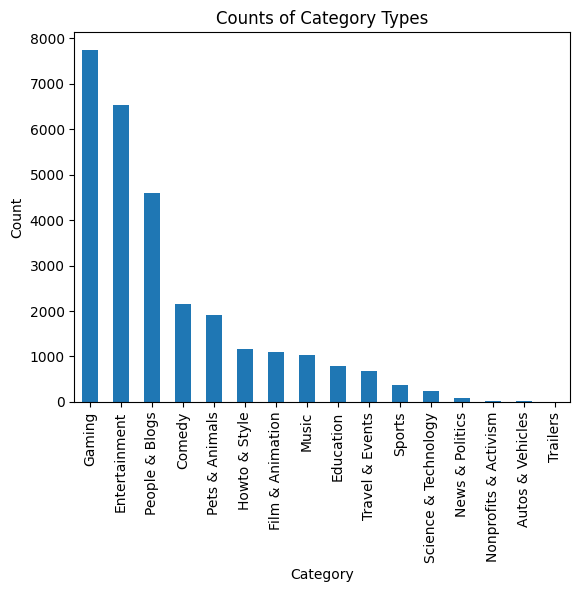

In [13]:
cat_counts = videos["Category"].value_counts()

cat_counts.plot(kind="bar")
plt.title("Counts of Category Types")
plt.ylabel("Count")
plt.xlabel("Category")


From the plot it can be seen that gaming videos are the most frequently watched category of videos. Lets group the videos dataset according to the category and list the mean view, like, and comment counts for each one.

In [14]:
grouped = videos.groupby("Category")[["View Count", "Like Count", "Comment Count"]].mean()
grouped

View Count     Like Count  Comment Count
Category                                                         
Autos & Vehicles       6.951393e+05   11070.800000     860.700000
Comedy                 7.037875e+06  183132.138760   10255.543056
Education              3.287391e+06  116505.432778    6606.301158
Entertainment          9.278229e+06  200567.937864    9308.312639
Film & Animation       8.714130e+06  210747.325751   13541.422078
Gaming                 3.338422e+06  114072.845489    5522.224938
Howto & Style          6.186834e+06  131191.079585    7753.477056
Music                  3.616509e+07  463825.213873   25565.373541
News & Politics        7.288559e+06  162131.517647    8166.734940
Nonprofits & Activism  1.035038e+07  184121.666667   10098.200000
People & Blogs         3.596483e+06   91132.625708    4740.905779
Pets & Animals         3.183866e+06   62166.791014    4639.040378
Science & Technology   1.294245e+07  285639.552632   11599.234513
Sports                 4.104786e+06   75600.013889    4370.030641
Trailers               1.009833e+06     526.333333      33.000000
Travel & Events        3.769180e+06   48717.917910    2804.491045

From the table above it is hard to tell whether the category I watched may or may not have an effect on the mean statistics at least for the view and like count. Let's do an ANOVA test to see whether accross the categories I watched there are any statistically significant differences in the view, like, or comment count. For our ANOVA test lets mark our statistical significance as α = .05 and state our null hypothesis as categories do not affect the view, like, or comment count.

In [15]:
view_anova = stats.f_oneway(videos[videos["Category"]=="Autos & Vehicles"]["View Count"], videos[videos["Category"]=="Comedy"]["View Count"], videos[videos["Category"]=="Education"]["View Count"], videos[videos["Category"]=="Entertainment"]["View Count"], videos[videos["Category"]=="Film & Animation"]["View Count"], videos[videos["Category"]=="Gaming"]["View Count"], videos[videos["Category"]=="Howto & Style"]["View Count"], videos[videos["Category"]=="Music"]["View Count"], videos[videos["Category"]=="News & Politics"]["View Count"], videos[videos["Category"]=="Nonprofits & Activism"]["View Count"], videos[videos["Category"]=="People & Blogs"]["View Count"], videos[videos["Category"]=="Pets & Animals"]["View Count"], videos[videos["Category"]=="Science & Technology"]["View Count"], videos[videos["Category"]=="Sports"]["View Count"], videos[videos["Category"]=="Travel & Events"]["View Count"], nan_policy="omit")
like_anova = stats.f_oneway(videos[videos["Category"]=="Autos & Vehicles"]["Like Count"], videos[videos["Category"]=="Comedy"]["Like Count"], videos[videos["Category"]=="Education"]["Like Count"], videos[videos["Category"]=="Entertainment"]["Like Count"], videos[videos["Category"]=="Film & Animation"]["Like Count"], videos[videos["Category"]=="Gaming"]["Like Count"], videos[videos["Category"]=="Howto & Style"]["Like Count"], videos[videos["Category"]=="Music"]["Like Count"], videos[videos["Category"]=="News & Politics"]["Like Count"], videos[videos["Category"]=="Nonprofits & Activism"]["Like Count"], videos[videos["Category"]=="People & Blogs"]["Like Count"], videos[videos["Category"]=="Pets & Animals"]["Like Count"], videos[videos["Category"]=="Science & Technology"]["Like Count"], videos[videos["Category"]=="Sports"]["Like Count"], videos[videos["Category"]=="Travel & Events"]["Like Count"], nan_policy="omit")
comment_anova = stats.f_oneway(videos[videos["Category"]=="Autos & Vehicles"]["Comment Count"], videos[videos["Category"]=="Comedy"]["Comment Count"], videos[videos["Category"]=="Education"]["Comment Count"], videos[videos["Category"]=="Entertainment"]["Comment Count"], videos[videos["Category"]=="Film & Animation"]["Comment Count"], videos[videos["Category"]=="Gaming"]["Comment Count"], videos[videos["Category"]=="Howto & Style"]["Comment Count"], videos[videos["Category"]=="Music"]["Comment Count"], videos[videos["Category"]=="News & Politics"]["Comment Count"], videos[videos["Category"]=="Nonprofits & Activism"]["Comment Count"], videos[videos["Category"]=="People & Blogs"]["Comment Count"], videos[videos["Category"]=="Pets & Animals"]["Comment Count"], videos[videos["Category"]=="Science & Technology"]["Comment Count"], videos[videos["Category"]=="Sports"]["Comment Count"], videos[videos["Category"]=="Travel & Events"]["Comment Count"], nan_policy="omit")

print("ANOVA for View Count:")
print("F-statistic:", view_anova.statistic)
print("p-value:", view_anova.pvalue)

print("\nANOVA for Like Count:")
print("F-statistic:", like_anova.statistic)
print("p-value:", like_anova.pvalue)

print("\nANOVA for Comment Count:")
print("F-statistic:", comment_anova.statistic)
print("p-value:", comment_anova.pvalue)

ANOVA for View Count:
F-statistic: 60.500591309938855
p-value: 3.982746306618048e-169

ANOVA for Like Count:
F-statistic: 51.617927068847294
p-value: 2.999237540094993e-143

ANOVA for Comment Count:
F-statistic: 34.1540360427735
p-value: 2.720894597885004e-92


Looking at the results of the ANOVA tests we can see that each test has produced a p value much less than .05, our chosen level of significance. This indicates that based on my watch history, the like, comment, and view counts are statistically different accross the different categories and we can reject the null hypothesis. We can better visualize this through displaying boxplots of each of the different categories.

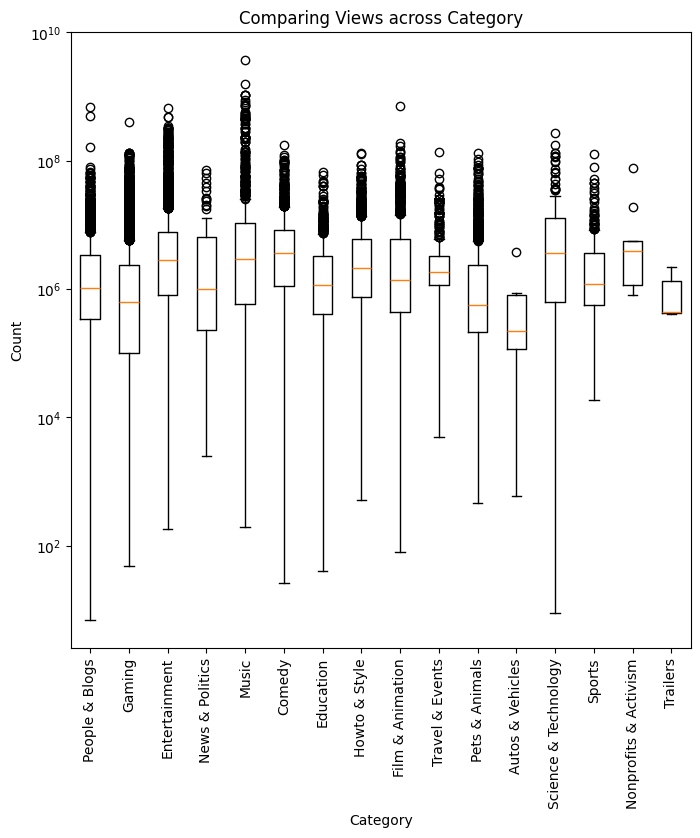

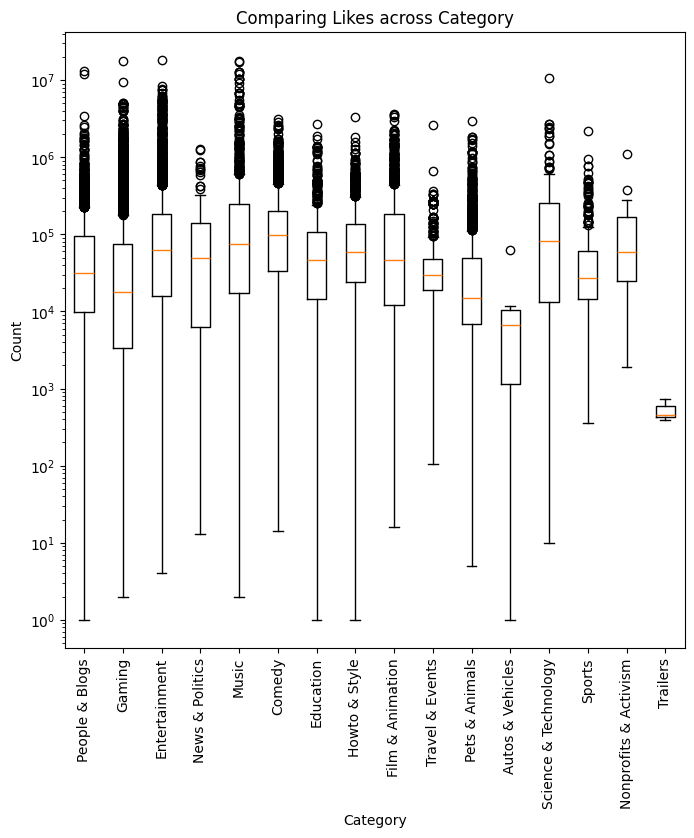

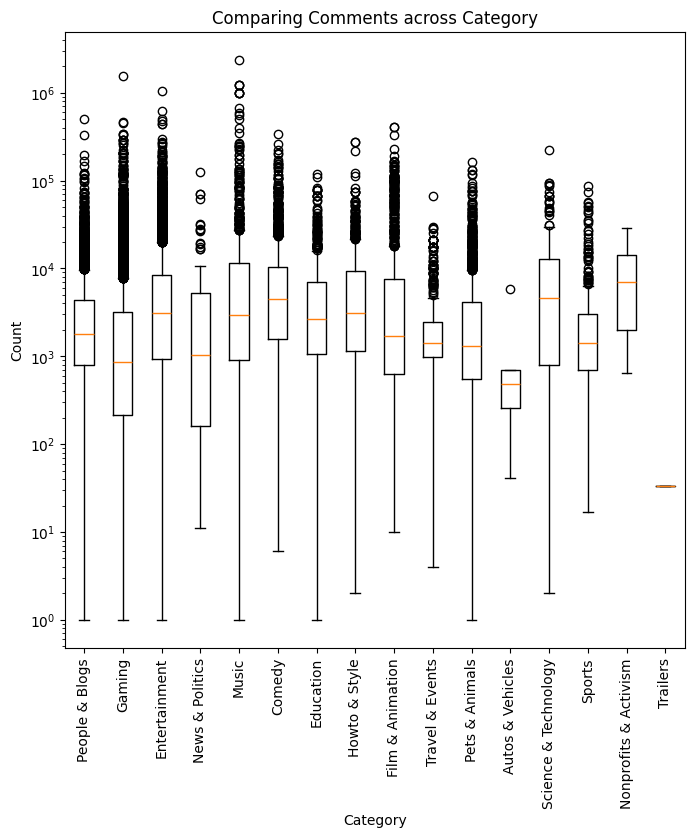

In [16]:
plt.figure(figsize=(8, 8))
plt.ylim()
plt.yscale('log')
plt.boxplot([videos[videos["Category"] == cat]["View Count"][videos["View Count"] > 0] for cat in videos["Category"].unique()], labels=videos["Category"].unique())
plt.ylabel("Count")
plt.xlabel("Category")
plt.title("Comparing Views across Category")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 8))
plt.ylim()
plt.yscale('log')
plt.boxplot([videos[videos["Category"] == cat]["Like Count"][videos["Like Count"] > 0] for cat in videos["Category"].unique()], labels=videos["Category"].unique())
plt.ylabel("Count")
plt.xlabel("Category")
plt.title("Comparing Likes across Category")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 8))
plt.ylim()
plt.yscale('log')
plt.boxplot([videos[videos["Category"] == cat]["Comment Count"][videos["Comment Count"] > 0] for cat in videos["Category"].unique()], labels=videos["Category"].unique())
plt.ylabel("Count")
plt.xlabel("Category")
plt.title("Comparing Comments across Category")
plt.xticks(rotation=90)
plt.show()


From the ANOVA test we have been able to see that the counts for views, likes, and comments are statistically different accross some of the categories. To better determine which of the categories is statistically different it would require further follow up testing. Let's also see if there are any correlations between view, like, and comment counts for all videos. For this we will use a correlation matrix to see if there are any positive or negative correlations between the three counts

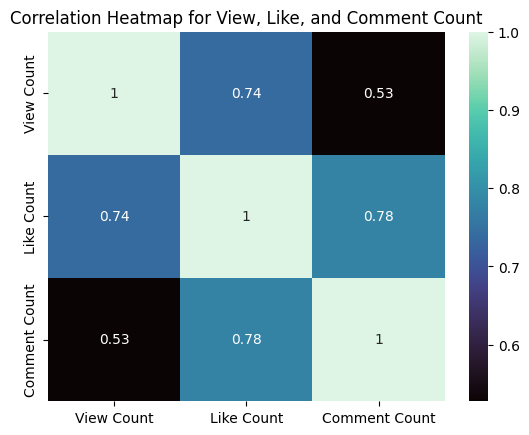

In [17]:
corr_mat = videos[["View Count", "Like Count", "Comment Count"]].corr()
sns.heatmap(corr_mat, annot=True, cmap="mako")
plt.title("Correlation Heatmap for View, Like, and Comment Count")
plt.show()

From the correlation matrix we have generated a heatmap to better display how strong the correlations are. A correlation coefficient close to positive 1 indicates a strong positive correlation between the two variables. So if one variable increases then it is likely that the other variable will also increase. From the graph we can see that the coefficient between views and likes is .74 which is close to 1. This indicates that there is a strong positive correlation between views and likes. Similarly the coefficient between likes and comments is .78 which indicates an even stronger correlation between likes and comments. The correlation coefficient between comments and views is .53 which indicates that there is a moderate correlation between views and comments.

Next lets examine whether the average video duration has changed from recent years compared to previous years. First lets categorize videos into recent which I will count as videos from the last year in the dataset, and old which I will count as videos from the first year of the dataset.

In [18]:
recent_videos = videos[videos["Date Watched"] >= videos["Date Watched"].max() - pd.DateOffset(years=1)].reset_index(drop=True)

old_videos = videos[videos["Date Watched"] <= videos["Date Watched"].min() + pd.DateOffset(years=1)].reset_index(drop=True)

Now that we have our two filtered sets, I will perform a two sample t-test to compare the mean watch time from the first and past year. For our null hypothesis we will state that there is no significant difference between the mean video duration between videos from the first year and videos watched within the past year. The alternative hypothesis will be that there is a significant difference between the video durations. Our level of significance will be set as α = .05.

In [19]:
res = stats.ttest_ind(old_videos["Duration (Min)"], recent_videos["Duration (Min)"])

print("T test statistic: ", res.statistic)
print("p value: ", res.pvalue)

T test statistic:  -20.976805862045513
p value:  8.398484775659094e-96


From the results of the t-test we can see that the p value is extremely small and falls below α = .05. This means that we can reject the null hypothesis. To better visualize the difference in video duration let's plot the durations. Since there are many many videos in each set I will find the average duration for videos watched per month. Since the dates for both sets don't align perfectly to start in January and instead correlate to months before/after a year off the end or beginning I've labeled it as months in the year.

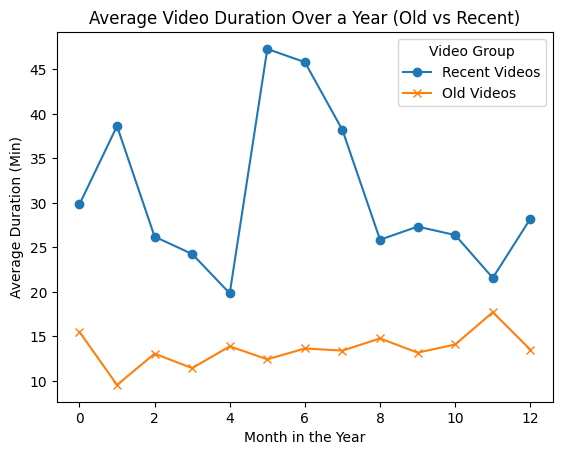

In [20]:
recent_avgs = recent_videos.groupby([recent_videos["Date Watched"].dt.year, recent_videos["Date Watched"].dt.month])["Duration (Min)"].mean().reset_index(drop=True)
old_avgs = old_videos.groupby([old_videos["Date Watched"].dt.year, old_videos["Date Watched"].dt.month])["Duration (Min)"].mean().reset_index(drop=True)

plt.plot(recent_avgs, label="Recent Videos", marker="o")
plt.plot(old_avgs, label='Old Videos', marker="x")
plt.title("Average Video Duration Over a Year (Old vs Recent)")
plt.xlabel("Month in the Year")
plt.ylabel("Average Duration (Min)")
plt.legend(title="Video Group")
plt.show()


From the graph above it makes sense on why the means are statistically different from each other as we can observe that on average for each month, the videos from the recent year are higher than those from the first year.

##**Further Analysis and Model Implementation**
From our basic dive into analyzing our data we can notice a few things. First is that our data is widely varied. Another is that time has affected at least one metric within the dataset. Lastly we see that there may be patterns within the many numerical features of the dataset. However, the initial analysis doesn't provide a lot of information on how view counts, likes, duration, etc. affect the videos that we watch.

Seeing that we have lots of numerical data and features within the dataset, let's use K-means clustering to further identify patterns in the data.

First things first let's import the libraries needed to create the model




In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

The one caveat to using K-means clustering is that it doesn't do well with categorical data such as the category of a video. This can be fixed through a little more data processing.

We can use one hot encoding to transform the categories into numerical data that can be used for clustering. This process takes each data point and assigns a binary value for each category to indicate if it applies or not. This technique is not always the best option if there are many categories to encode with a small dataset. In our case, we have well over 20,000 datapoints to utilize so one hot encoding should work well for us. This allows us to further capture patterns between each of the features.

 Lets also start separating out the features we want to cluster off of into a separate features dataframe.

In [22]:
features = videos[["View Count", "Like Count", "Comment Count", "Duration (Min)"]]
categories_encoded = pd.get_dummies(videos['Category'])
features = pd.concat([features, categories_encoded], axis=1)
features


View Count  Like Count  Comment Count  Duration (Min)  \
0       1247761.0     57619.0         1469.0        0.850000   
1         46724.0      3514.0           28.0        1.000000   
2         20657.0      2211.0           15.0        0.900000   
3       2049923.0    126350.0          752.0        0.933333   
4        111920.0      6318.0           46.0        0.566667   
...           ...         ...            ...             ...   
28414    493012.0      9738.0          775.0       19.733333   
28415    297159.0      6968.0          861.0       11.283333   
28416    460051.0      9020.0          616.0       24.433333   
28417    390391.0      8607.0          484.0       13.450000   
28418    517716.0     11595.0         1417.0       17.083333   

       Autos & Vehicles  Comedy  Education  Entertainment  Film & Animation  \
0                 False   False      False          False             False   
1                 False   False      False          False             False   
2                 False   False      False           True             False   
3                 False   False      False          False             False   
4                 False   False      False          False             False   
...                 ...     ...        ...            ...               ...   
28414             False   False      False          False             False   
28415             False   False      False          False             False   
28416             False   False      False          False             False   
28417             False   False      False          False             False   
28418             False   False      False          False             False   

       Gaming  Howto & Style  Music  News & Politics  Nonprofits & Activism  \
0       False          False  False            False                  False   
1        True          False  False            False                  False   
2       False          False  False            False                  False   
3        True          False  False            False                  False   
4       False          False  False             True                  False   
...       ...            ...    ...              ...                    ...   
28414    True          False  False            False                  False   
28415    True          False  False            False                  False   
28416    True          False  False            False                  False   
28417    True          False  False            False                  False   
28418    True          False  False            False                  False   

       People & Blogs  Pets & Animals  Science & Technology  Sports  Trailers  \
0                True           False                 False   False     False   
1               False           False                 False   False     False   
2               False           False                 False   False     False   
3               False           False                 False   False     False   
4               False           False                 False   False     False   
...               ...             ...                   ...     ...       ...   
28414           False           False                 False   False     False   
28415           False           False                 False   False     False   
28416           False           False                 False   False     False   
28417           False           False                 False   False     False   
28418           False           False                 False   False     False   

       Travel & Events  
0                False  
1                False  
2                False  
3                False  
4                False  
...                ...  
28414            False  
28415            False  
28416            False  
28417            False  
28418            False  

[28419 rows x 20 columns]

We can observe that our features dataframe now contains our numerical data. One of the items of interest was to see if there was any relationship between the date and time that something was watched and the videos itself. Since K-means uses numerical data to calculate euclidean distances, times and dates do not work well in calculations. To get around this, we can do some isolation and conversion.

Months, days, hours, etc. all work on a cycle. As such we can normalize them through using sine and cosine functions. The reason why we use both sine and cosine functions is due to the fact that at certain points sin(x) or cos(x) can produce the same values. For example, sin(0) and sin(180) both produce a value of 0. Utilizing both sine and cosine coordinates we can avoid this duplication. Years will remain unaffected as they do not operate on a cycle.

For our conversion, we can use the following formulas:
$$\text{sin_coord} = sin(2π\frac{\text{val}}{\text{max_val}})$$
$$\text{cos_coord} = cos(2π\frac{\text{val}}{\text{max_val}})$$



In [24]:
features["hour_sin"] = np.sin(2 * np.pi * videos["Date Watched"].dt.hour / 24)
features["hour_cos"] = np.cos(2 * np.pi * videos["Date Watched"].dt.hour / 24)
features["day_sin"] = np.sin(2 * np.pi * videos["Date Watched"].dt.dayofweek / 7)
features["day_cos"] = np.cos(2 * np.pi * videos["Date Watched"].dt.dayofweek / 7)
features["month__sin"] = np.sin(2 * np.pi * videos["Date Watched"].dt.month / 12)
features["month_cos"] = np.cos(2 * np.pi * videos["Date Watched"].dt.month / 12)
features["year"] = videos["Date Watched"].dt.year
features

View Count  Like Count  Comment Count  Duration (Min)  \
0       1247761.0     57619.0         1469.0        0.850000   
1         46724.0      3514.0           28.0        1.000000   
2         20657.0      2211.0           15.0        0.900000   
3       2049923.0    126350.0          752.0        0.933333   
4        111920.0      6318.0           46.0        0.566667   
...           ...         ...            ...             ...   
28414    493012.0      9738.0          775.0       19.733333   
28415    297159.0      6968.0          861.0       11.283333   
28416    460051.0      9020.0          616.0       24.433333   
28417    390391.0      8607.0          484.0       13.450000   
28418    517716.0     11595.0         1417.0       17.083333   

       Autos & Vehicles  Comedy  Education  Entertainment  Film & Animation  \
0                 False   False      False          False             False   
1                 False   False      False          False             False   
2                 False   False      False           True             False   
3                 False   False      False          False             False   
4                 False   False      False          False             False   
...                 ...     ...        ...            ...               ...   
28414             False   False      False          False             False   
28415             False   False      False          False             False   
28416             False   False      False          False             False   
28417             False   False      False          False             False   
28418             False   False      False          False             False   

       Gaming  ...  Sports  Trailers  Travel & Events  hour_sin  hour_cos  \
0       False  ...   False     False            False -0.258819  0.965926   
1        True  ...   False     False            False -0.258819  0.965926   
2       False  ...   False     False            False -0.258819  0.965926   
3        True  ...   False     False            False -0.258819  0.965926   
4       False  ...   False     False            False -0.258819  0.965926   
...       ...  ...     ...       ...              ...       ...       ...   
28414    True  ...   False     False            False  0.000000  1.000000   
28415    True  ...   False     False            False  0.000000  1.000000   
28416    True  ...   False     False            False  0.000000  1.000000   
28417    True  ...   False     False            False  0.000000  1.000000   
28418    True  ...   False     False            False -0.500000  0.866025   

        day_sin  day_cos  month__sin     month_cos  year  
0      0.000000  1.00000   -0.866025  5.000000e-01  2024  
1      0.000000  1.00000   -0.866025  5.000000e-01  2024  
2      0.000000  1.00000   -0.866025  5.000000e-01  2024  
3      0.000000  1.00000   -0.866025  5.000000e-01  2024  
4      0.000000  1.00000   -0.866025  5.000000e-01  2024  
...         ...      ...         ...           ...   ...  
28414  0.781831  0.62349    1.000000  6.123234e-17  2018  
28415  0.781831  0.62349    1.000000  6.123234e-17  2018  
28416  0.781831  0.62349    1.000000  6.123234e-17  2018  
28417  0.781831  0.62349    1.000000  6.123234e-17  2018  
28418  0.000000  1.00000    1.000000  6.123234e-17  2018  

[28419 rows x 27 columns]

One last consideration to take into account is how to handle NaN values. For our initial analysis these NaN values did not affect anything, however, using K-means clustering needs valid numerical data. As such we need to now handle these values. Let's first take a look at how many NaN values we have within our features data.

In [30]:
print(features.isna().sum())

View Count                26
Like Count                46
Comment Count            641
Duration (Min)             0
Autos & Vehicles           0
Comedy                     0
Education                  0
Entertainment              0
Film & Animation           0
Gaming                     0
Howto & Style              0
Music                      0
News & Politics            0
Nonprofits & Activism      0
People & Blogs             0
Pets & Animals             0
Science & Technology       0
Sports                     0
Trailers                   0
Travel & Events            0
hour_sin                   0
hour_cos                   0
day_sin                    0
day_cos                    0
month__sin                 0
month_cos                  0
year                       0
dtype: int64


Looking at the views and likes count features, there are very few NaN points. These points make up less than 1% of out data. As for the comment counts, there are significantly more NaN values, however, this still makes up less than 3% of our total data. For these missing values, lets use imputation to fill in these NaN entries. For our analysis we will use median imputation which is replacing the NaN values with the median feature value. We choose the median to fill the values since there is wide variability within the dataset. As such, the mean will be more affected by outliers while the median will not.

In [35]:
features["View Count"] = features["View Count"].fillna(features["View Count"].median())
features["Like Count"] = features["Like Count"].fillna(features["Like Count"].median())
features["Comment Count"] = features["Comment Count"].fillna(features["Comment Count"].median())
print(features.isna().sum())

View Count               0
Like Count               0
Comment Count            0
Duration (Min)           0
Autos & Vehicles         0
Comedy                   0
Education                0
Entertainment            0
Film & Animation         0
Gaming                   0
Howto & Style            0
Music                    0
News & Politics          0
Nonprofits & Activism    0
People & Blogs           0
Pets & Animals           0
Science & Technology     0
Sports                   0
Trailers                 0
Travel & Events          0
hour_sin                 0
hour_cos                 0
day_sin                  0
day_cos                  0
month__sin               0
month_cos                0
year                     0
dtype: int64


Now we have all our desired features in a numerical state and we have no remaining NaN values we can start actually constructing the model! Lets start by standardizing everything.

In [77]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

This standardization will ensure that no bias is introduced on account of our data having different scales. Now let's cluster our data! To start, we need to choose a desired number of clusters. Let's start with 3 clusters for our data.







In [78]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features_scaled)
features["Cluster"] = kmeans.labels_

We've arbitrarily chosen 3 clusters for our dataset. Let's visualize the result to see how the clusters look. First step is to reduce the dimension. We have many features which complicates our visualization as it means that the datapoints will be spread accross many dimensions making it hard to comprehend.

We will apply Principal Component Analysis (PCA) which will reduce our dimensions while maintaining variance within the dataset.

Text(0, 0.5, 'PCA2')

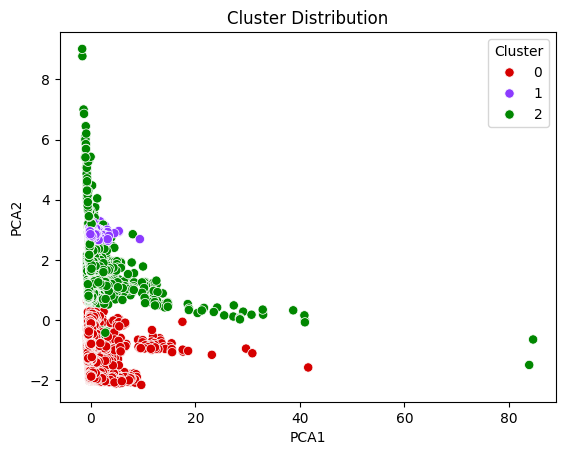

In [79]:
from sklearn.decomposition import PCA
import colorcet  as cc
palette = sns.color_palette(cc.glasbey, n_colors=3)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

sns.scatterplot(x=features_pca[:, 0],y=features_pca[:, 1], hue="Cluster", data=features,s=45,legend="full", palette=palette)
plt.title("Cluster Distribution")
plt.xlabel("PCA1")
plt.ylabel("PCA2")



Looking at this plot it can be seen that the clusters are not distinct at all! This is likely because PCA works by using linear transformations which don't capture all of the relationships. In this case, our dataset seems to have many non-linear relationships in which case using [t-Distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (t-SNE) will be a better fit. t-SNE utilizes probability and gaussian distributions to capture non-linear data.

Text(0, 0.5, 't-SNE2')

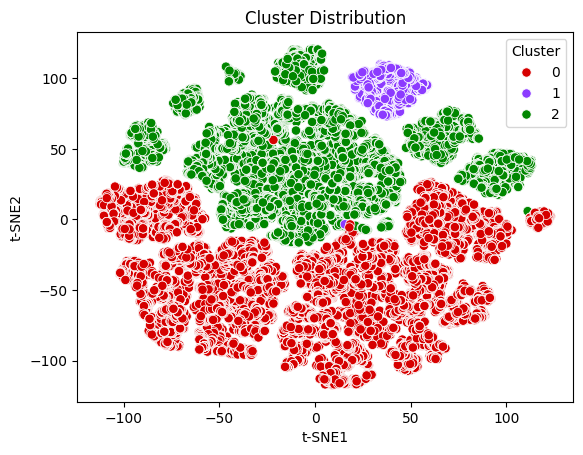

In [80]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

sns.scatterplot(x=features_tsne[:, 0],y=features_tsne[:, 1], hue="Cluster", data=features,s=45,legend="full", palette=palette)
plt.title("Cluster Distribution")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")

Visually this t-SNE plot looks much better! We can actually see some clusters. However, the clusters are strangely grouped. It seems that within each cluster there are a few sub-clusters. This is likely due to us arbitrarily choosing the number 3 for our clusters. Since our data is complex, this most likely is not enough to accurately capture the patterns. Lets try finding a more appropriate cluster number using the Elbow method (https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/#).

The elbow method will allow us to visually determine an optimal k value for our clustering. We vary the number of clusters and plot a calculated Within-Cluster-Sum of Squared Errors (WSS), in this case labeled as inertia.

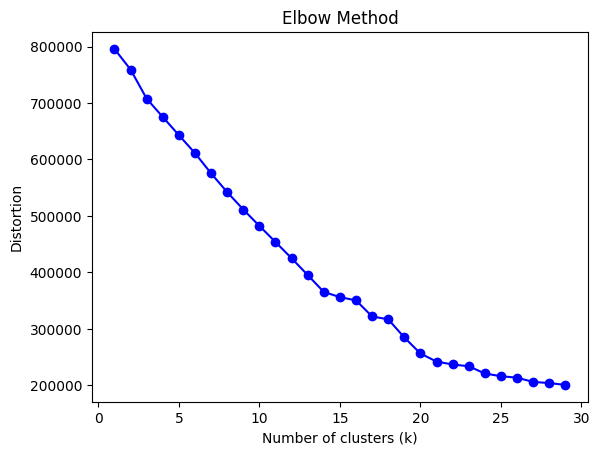

In [81]:
inertias = []

for k in range(1, 30):
    # Building and fitting each model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Plotting
plt.plot(range(1,30), inertias, 'bo-', label='Inertias')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

Looking at this plot we seemingly have two elbows, one around the 15 cluster point and one around the 20 cluster point. To clarify what the ideal cluster number is, we can evaluate the silhouette score of each model. (https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

The silhouette score describes how well separated each cluster is. Higher silhouette scores indicate that a cluster is farther away from another. As such we can plot the silhouette score for each of the models in range 5 to 25. This will better clarify what number to use for our k.

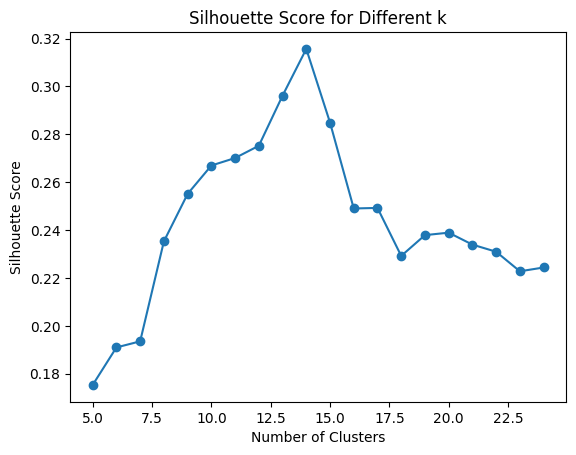

In [82]:
from sklearn.metrics import silhouette_score

#calc score for ks 5 to 25 to help determine good k value
sil_scores = []
for k in range(5, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    score = silhouette_score(features_scaled, kmeans.labels_)
    sil_scores.append(score)

plt.plot(range(5, 25), sil_scores, marker='o')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

From this plot we can see that a model using 14 clusters seems to provide the best fit. This matches the first elbow point from the previous graph. Now that we have our new k value, lets try re-visualizing the K-means using k=14.

Text(0, 0.5, 't-SNE2')

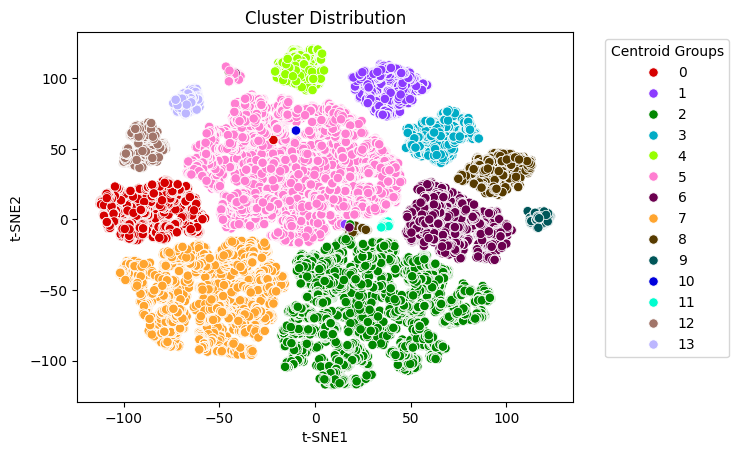

In [112]:
kmeans = KMeans(n_clusters=14, random_state=42)
kmeans.fit(features_scaled)
features["Cluster"] = kmeans.labels_
palette = sns.color_palette(cc.glasbey, n_colors=14)

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

sns.scatterplot(x=features_tsne[:, 0],y=features_tsne[:, 1], hue="Cluster", data=features, s=45, palette=palette)
plt.legend(title="Centroid Groups", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Cluster Distribution")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")

Great! These results have improved how separated the clusters are. Now lets analyze what features were most important in the clustering. We can do this by examining the centroids of each cluster. Let's plot the values of the features that contribute to each centroid.

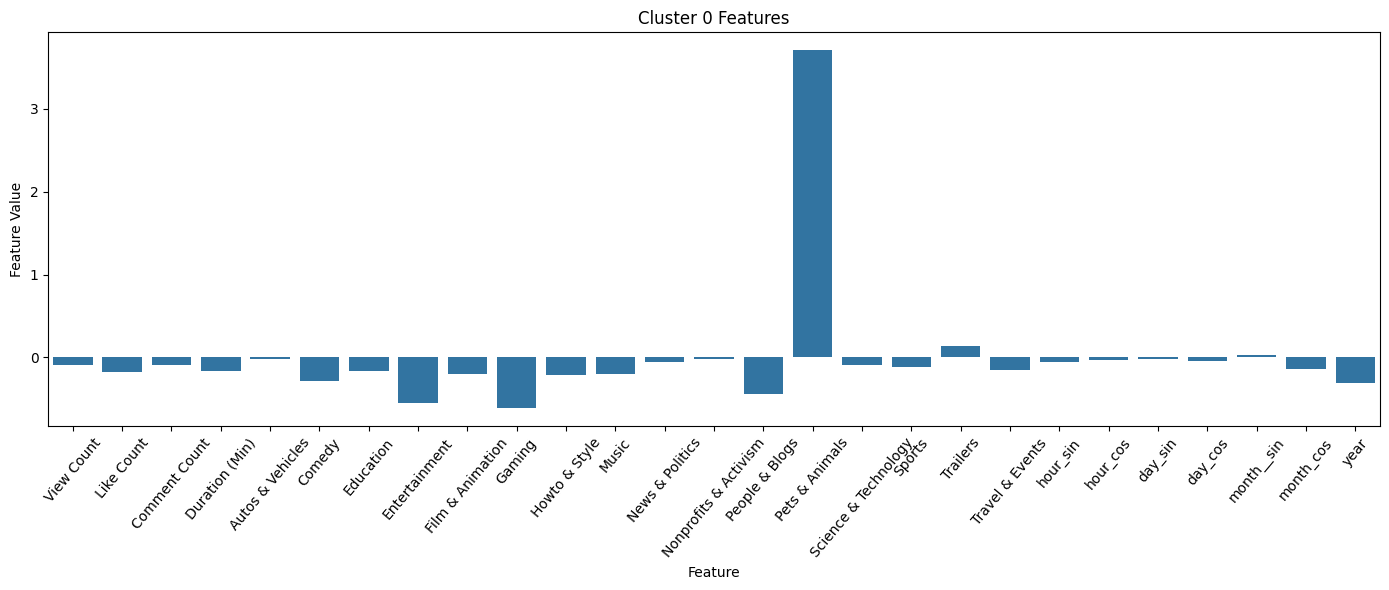

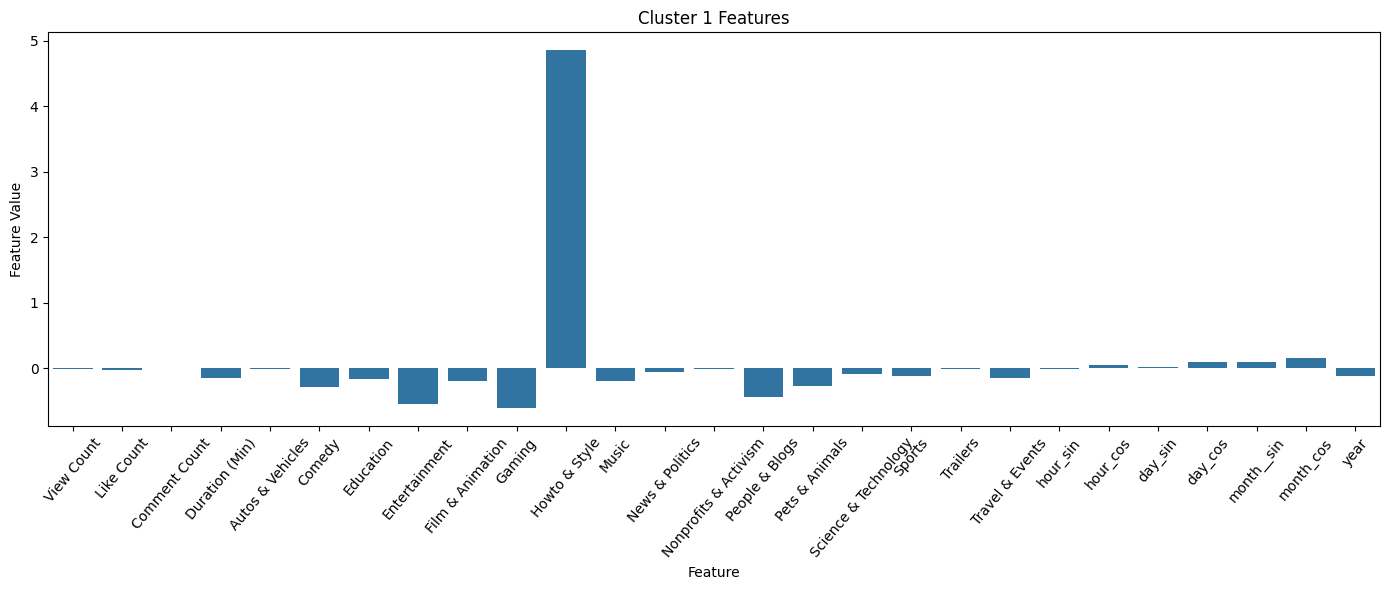

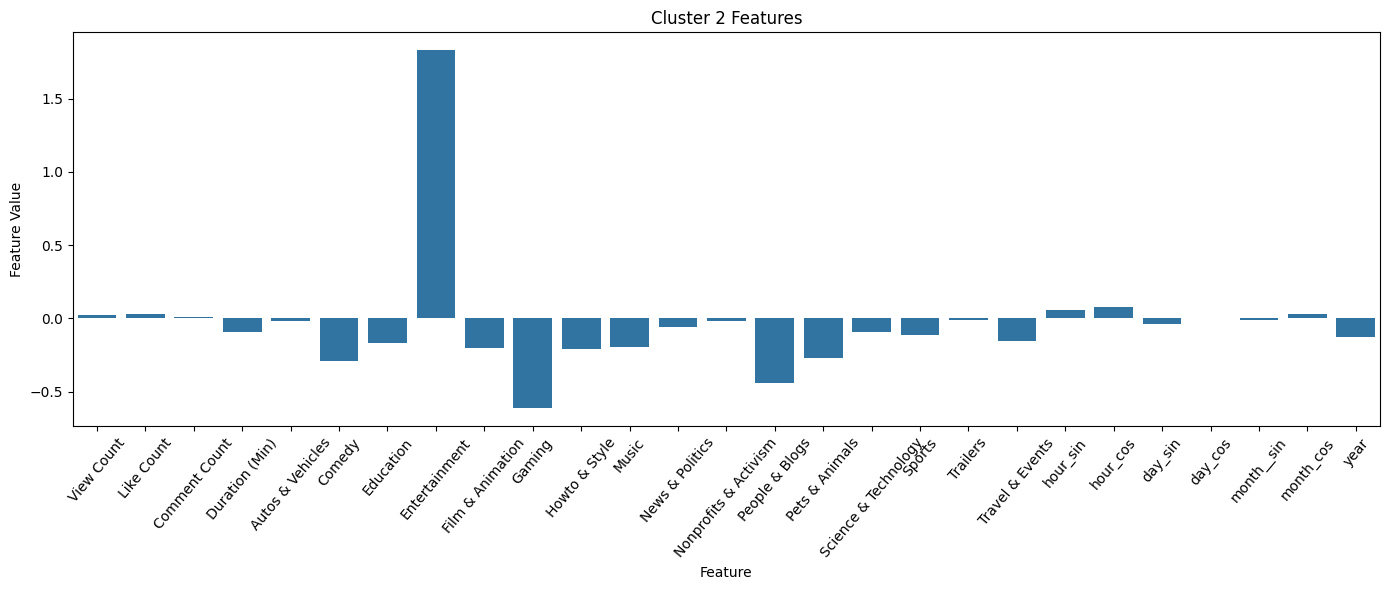

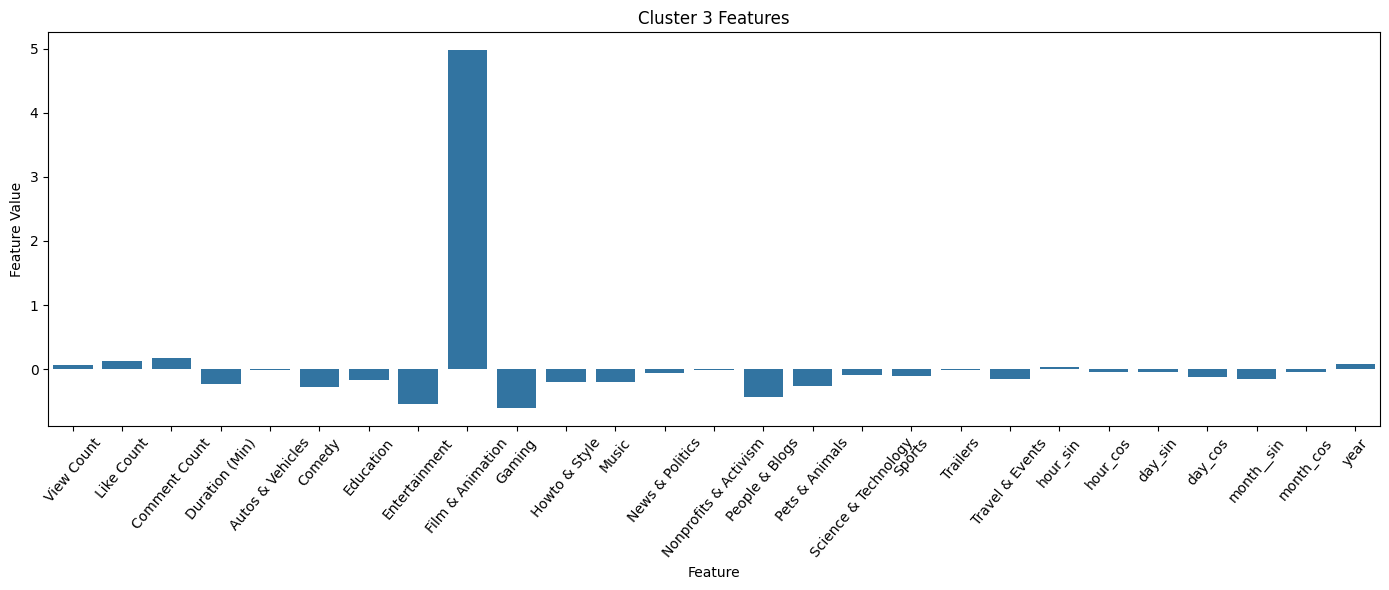

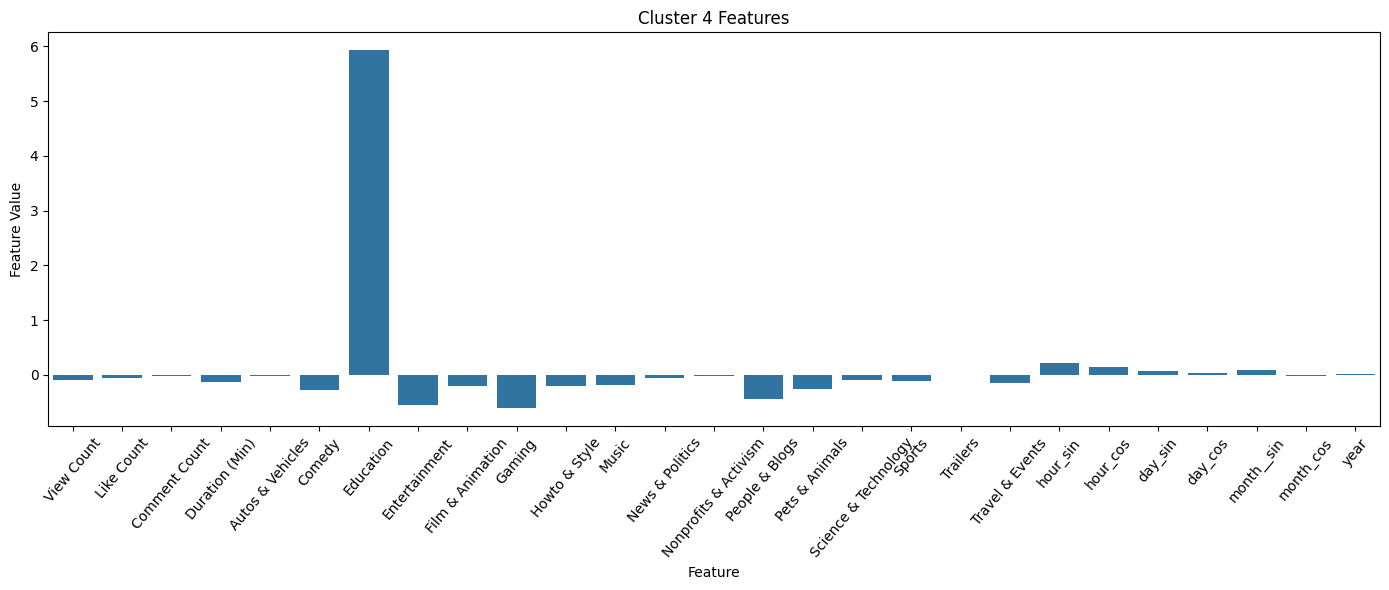

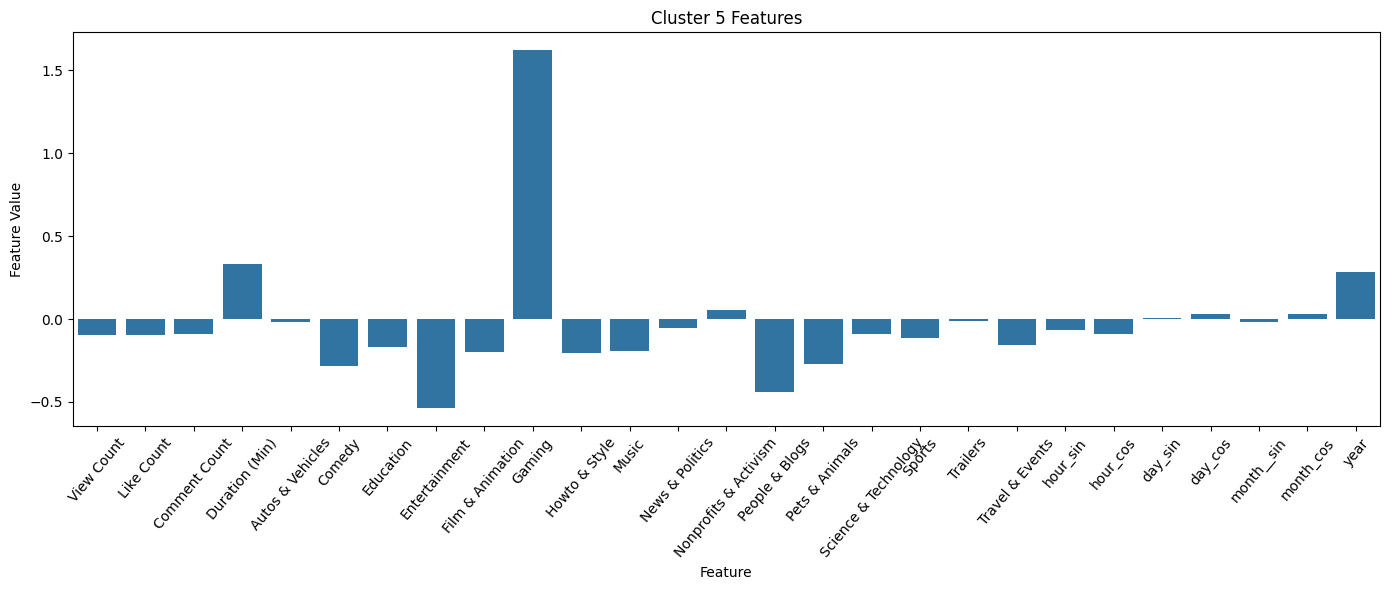

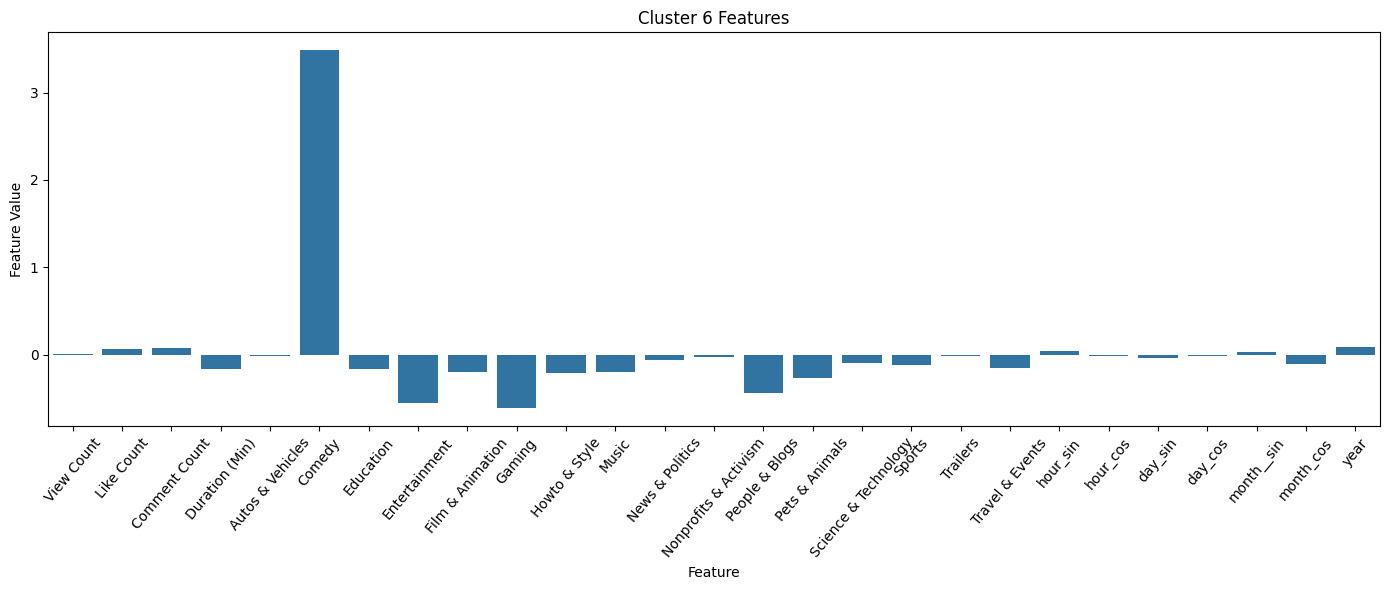

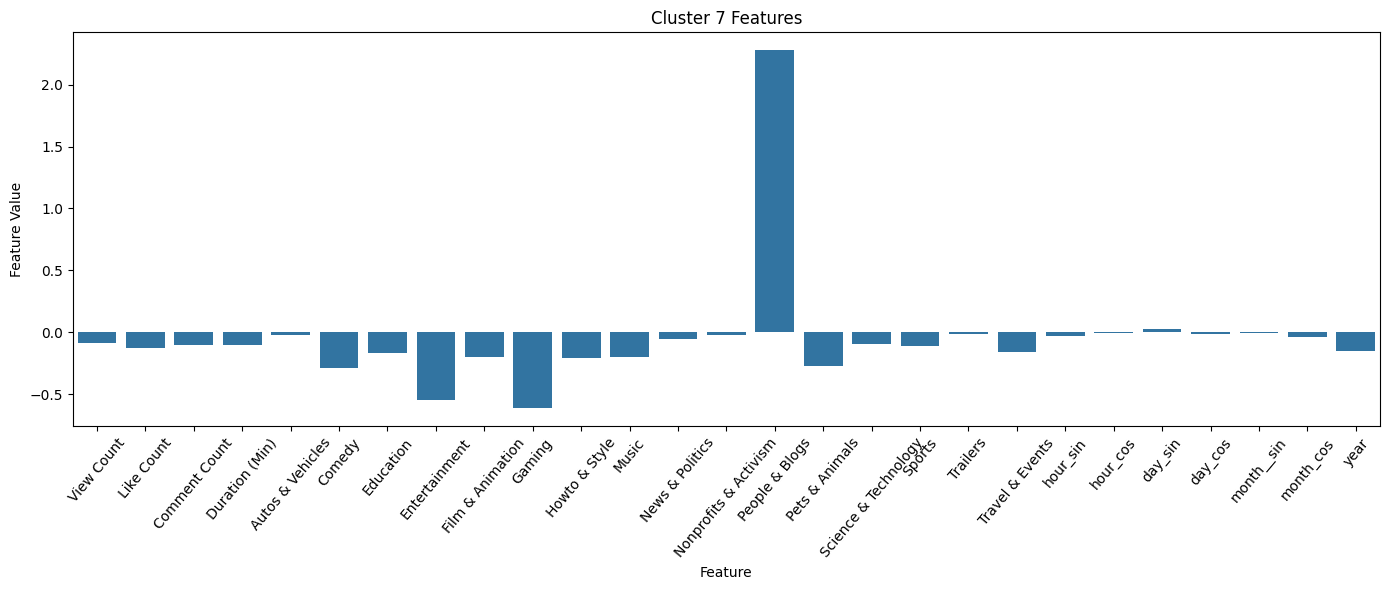

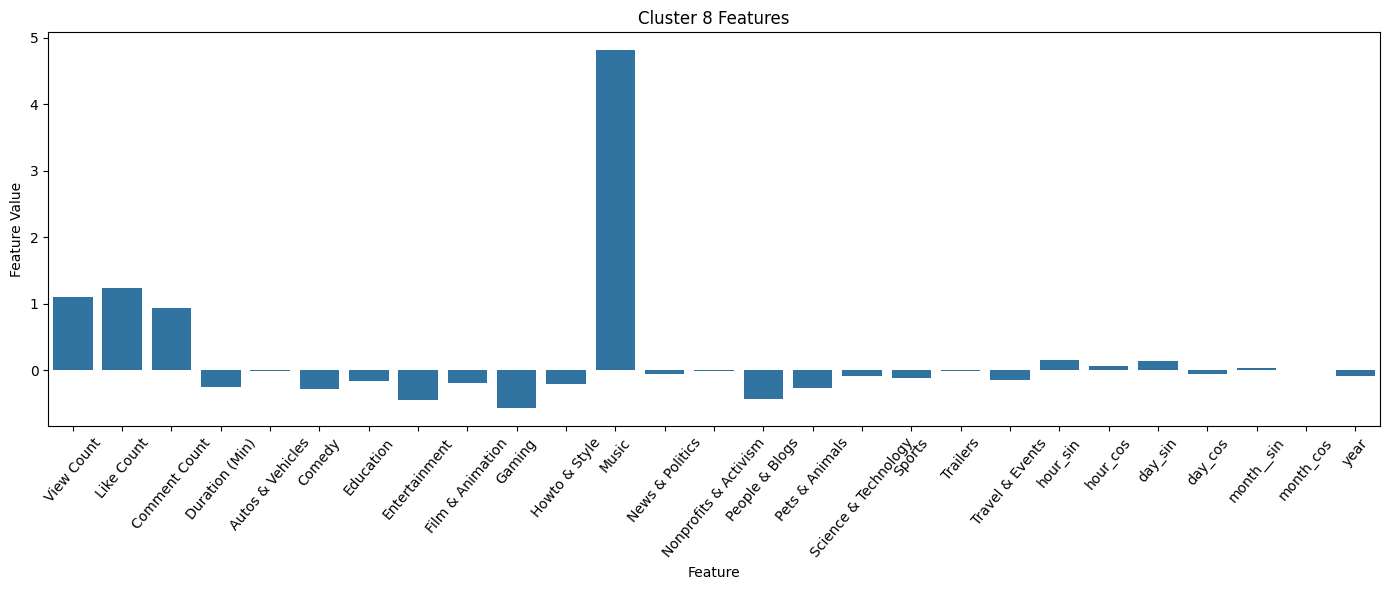

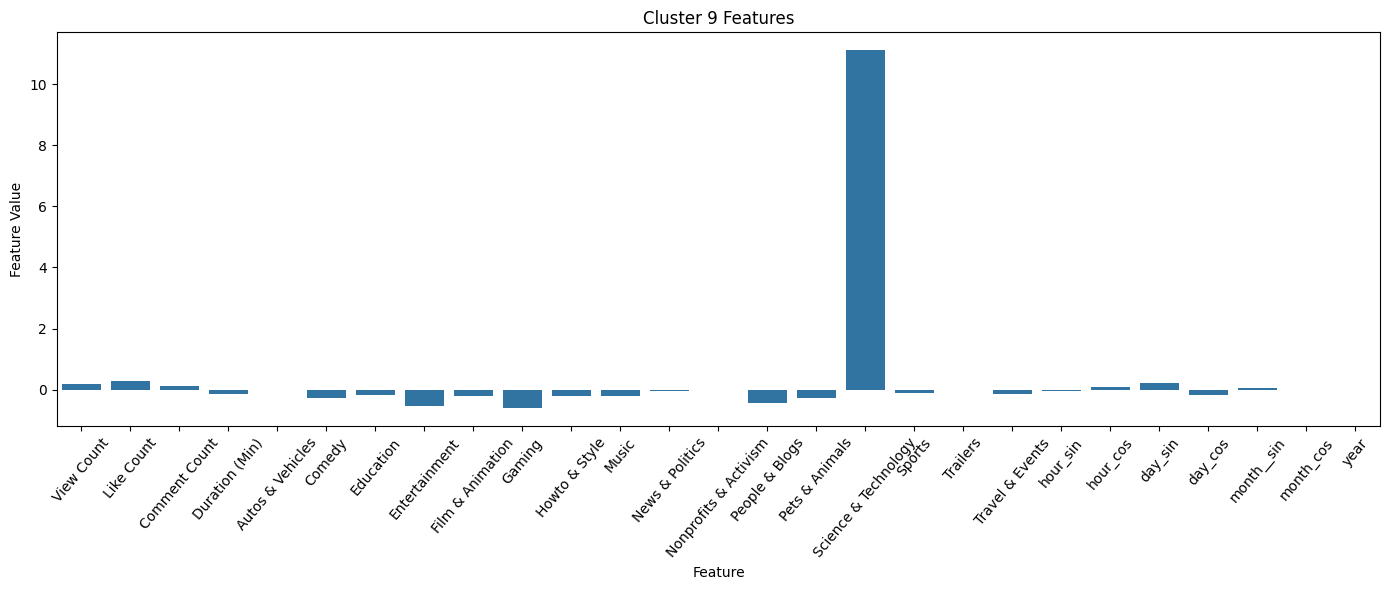

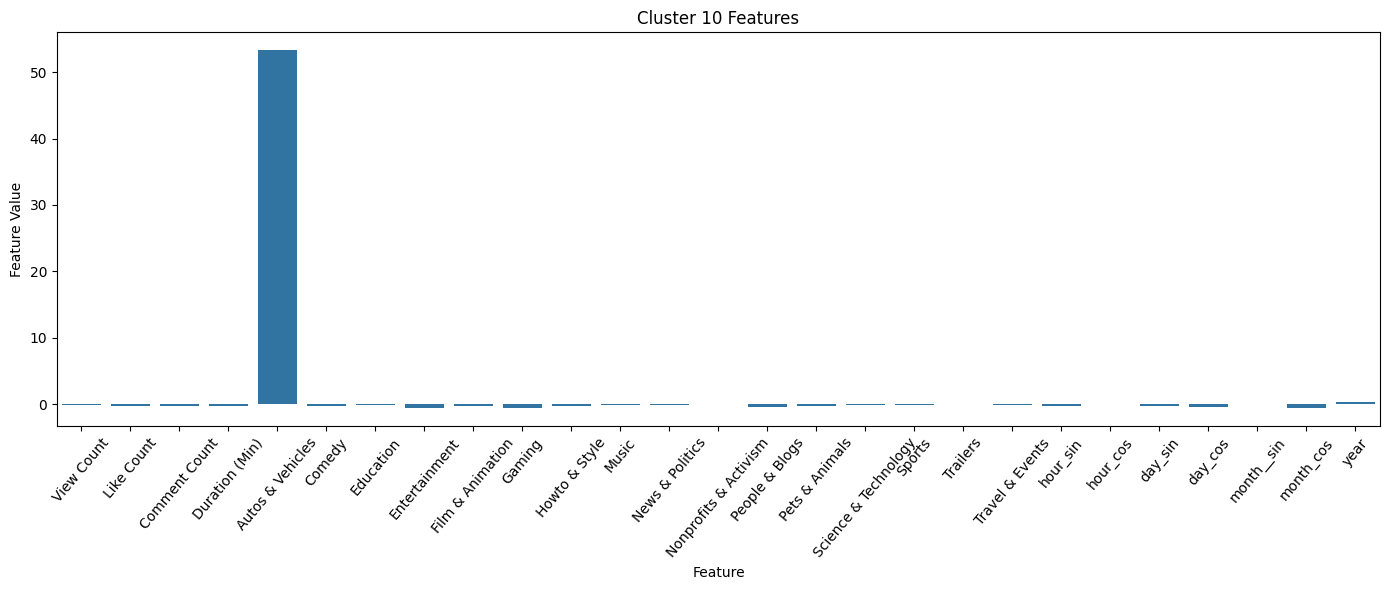

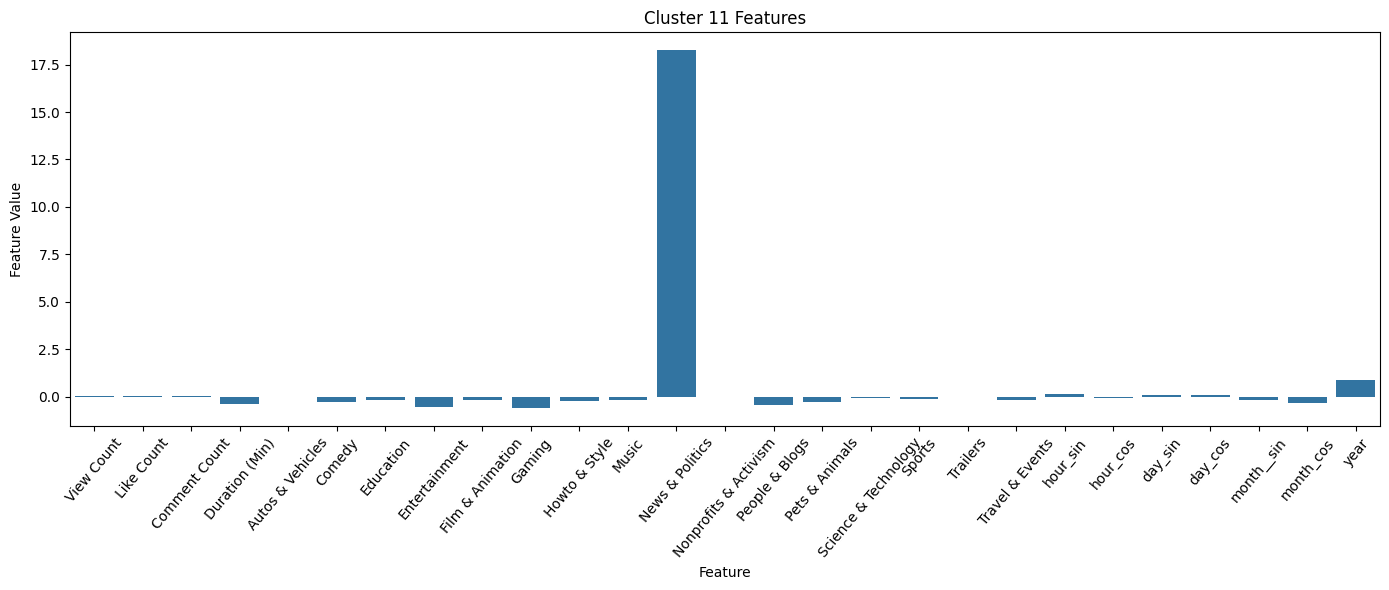

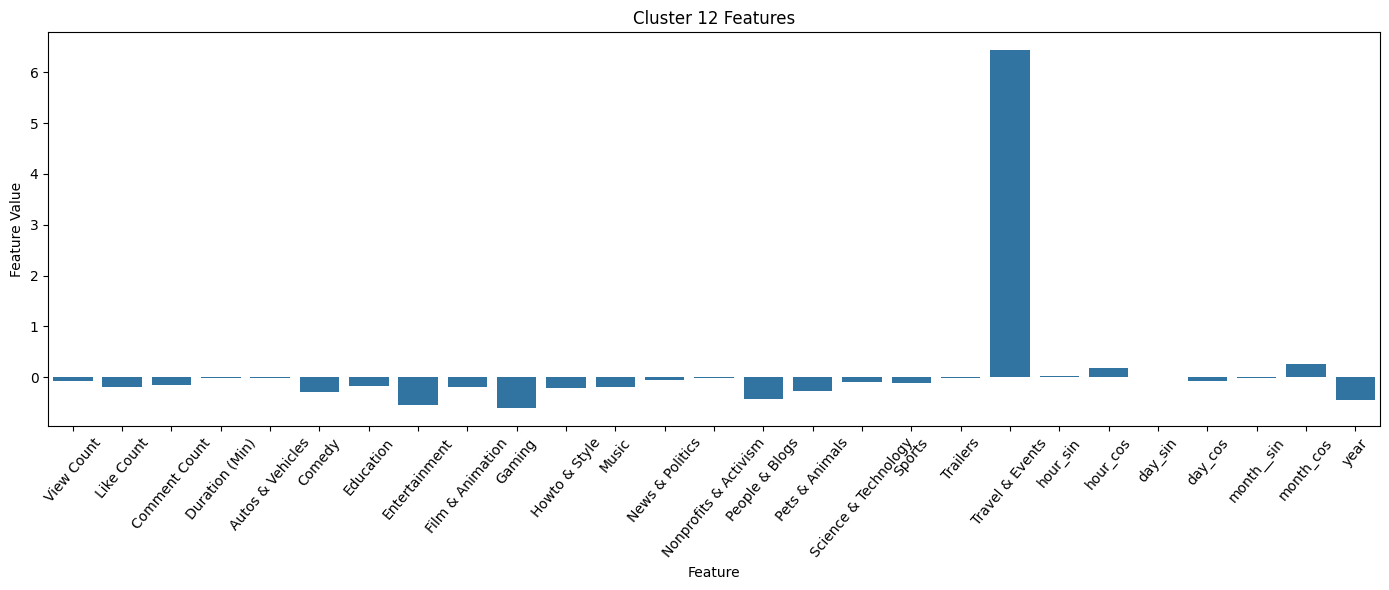

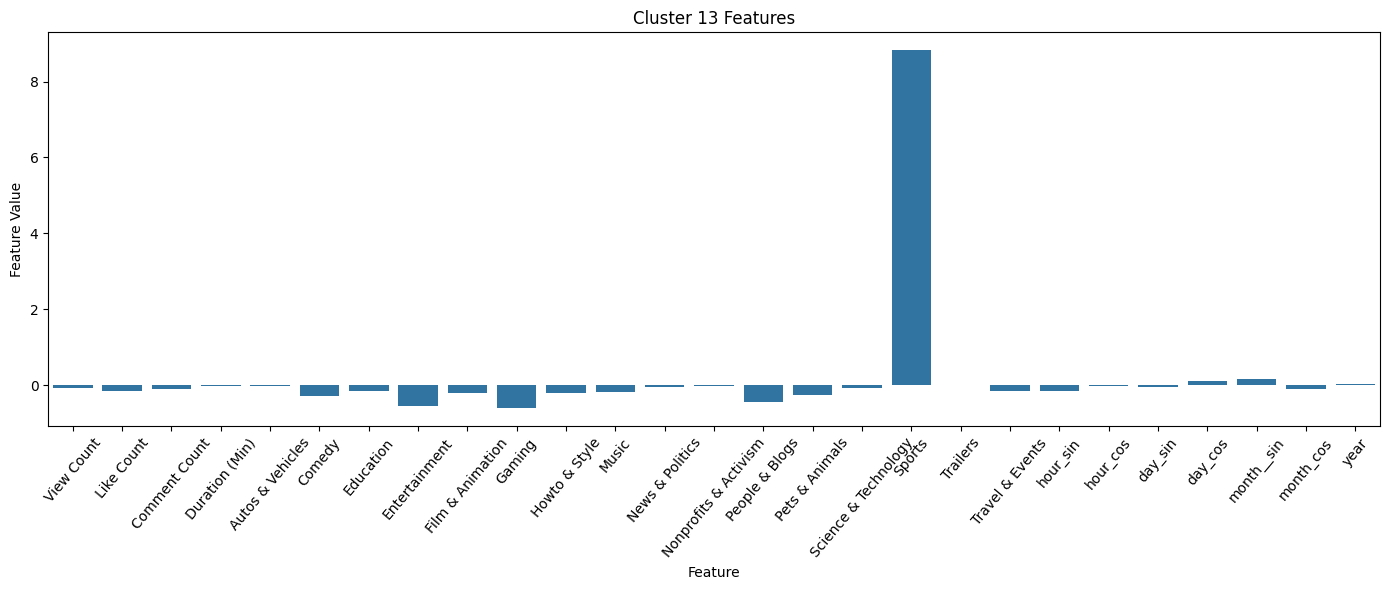

In [158]:

centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=features.columns)
centroids_df = centroids_df.drop(columns=["Cluster"])

#save the main feature for later
cluster_mapping = {}

#plotting feature contributions
for i, centroid in enumerate(centroids_df.values):
    plt.figure(figsize=(14, 6))
    sns.barplot(x=centroids_df.columns, y=centroid)

    cluster_mapping[i] = centroids_df.columns[np.argmax(centroid)]

    plt.title(f"Cluster {i} Features")
    plt.xlabel("Feature")
    plt.ylabel("Feature Value")
    plt.xticks(rotation=50)
    plt.tight_layout()
    plt.show()

In summary the following is mapping of the cluster to the primary feature:

In [159]:
cluster_mapping

{0: 'Pets & Animals',
 1: 'Howto & Style',
 2: 'Entertainment',
 3: 'Film & Animation',
 4: 'Education',
 5: 'Gaming',
 6: 'Comedy',
 7: 'People & Blogs',
 8: 'Music',
 9: 'Science & Technology',
 10: 'Autos & Vehicles',
 11: 'News & Politics',
 12: 'Travel & Events',
 13: 'Sports'}

From these graphs we can see that they are mainly clustered based on the category. This indicates that out of all the given features, the category a video falls into was the strongest determining factor. It suggests that the patterns influenced by time were not as strong. But, using these clusters we can graph how the average number of video occurances changed over time. We can use a rolling mean for our plotting.

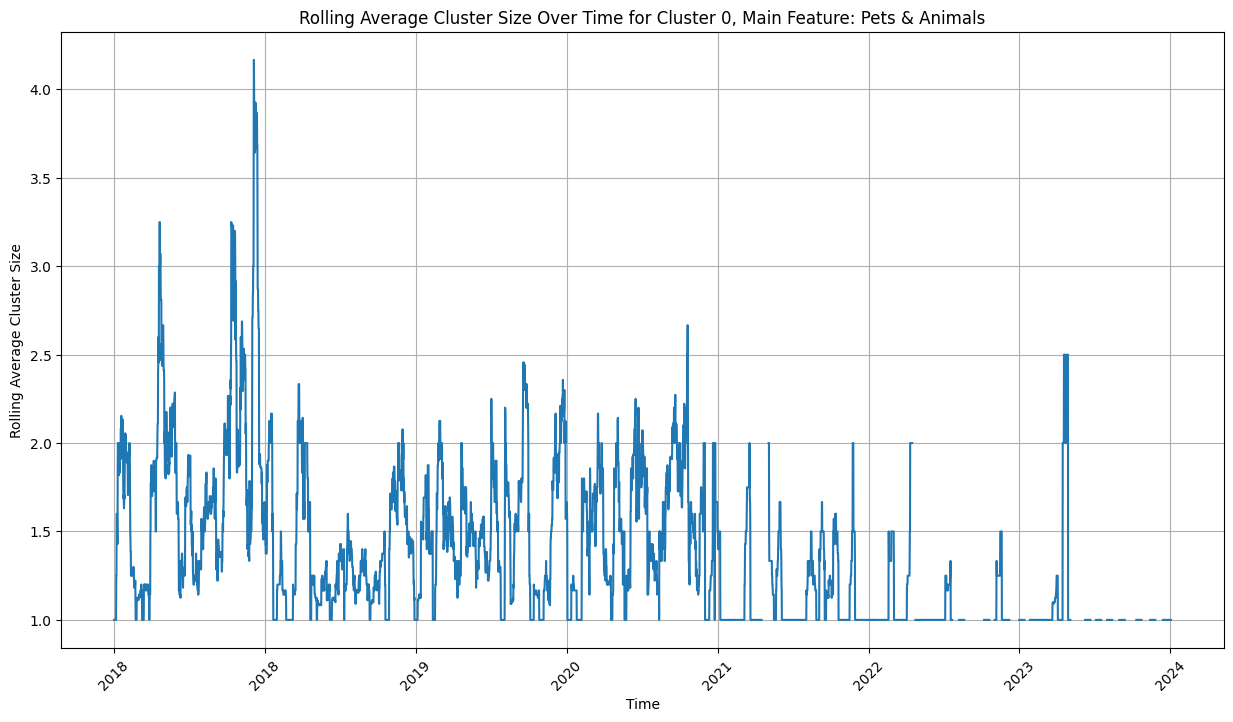

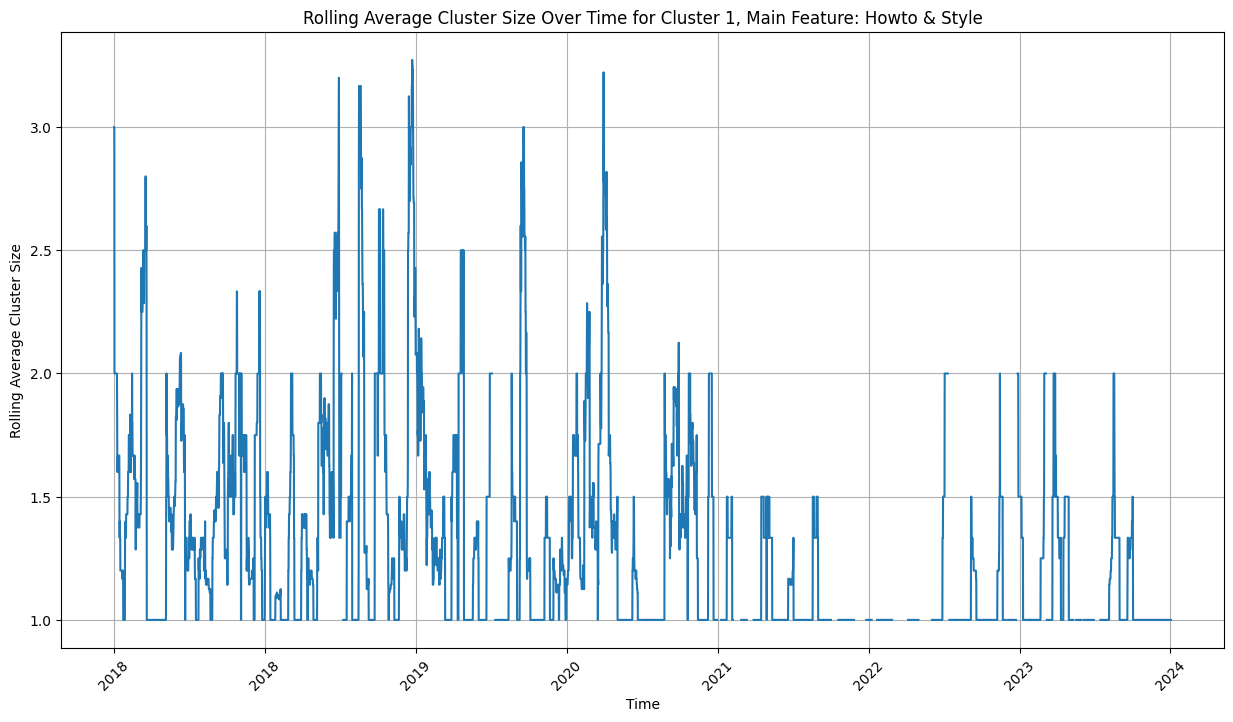

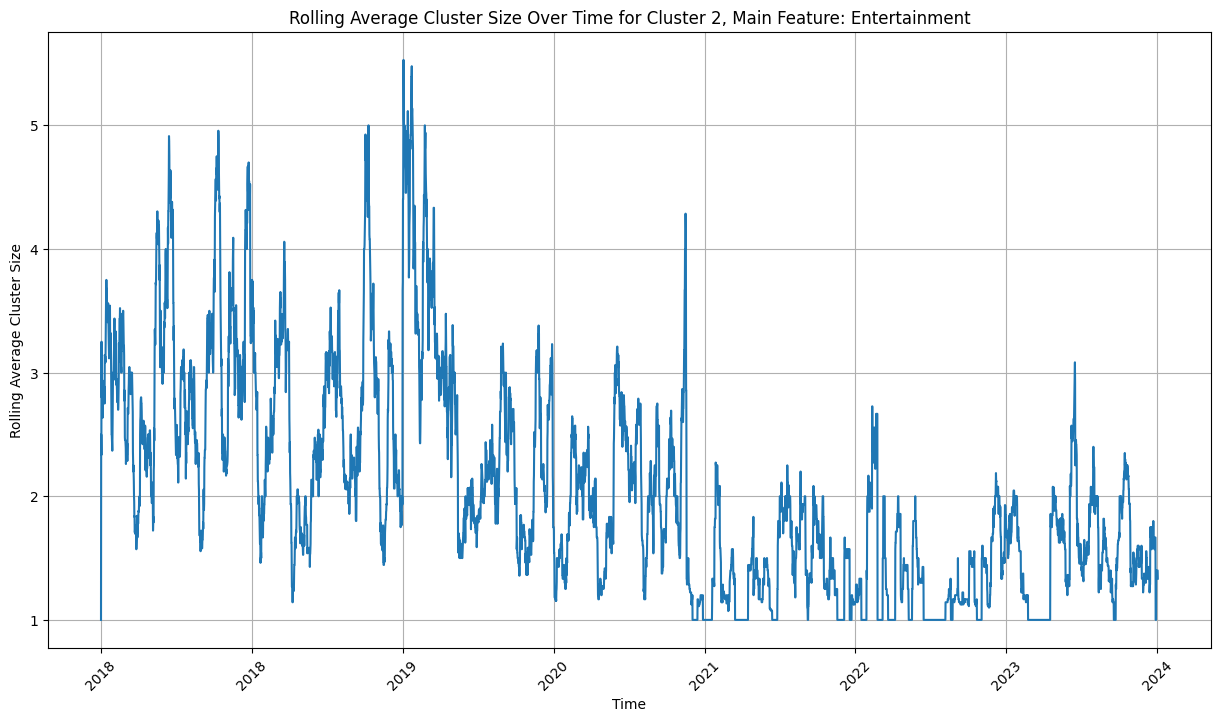

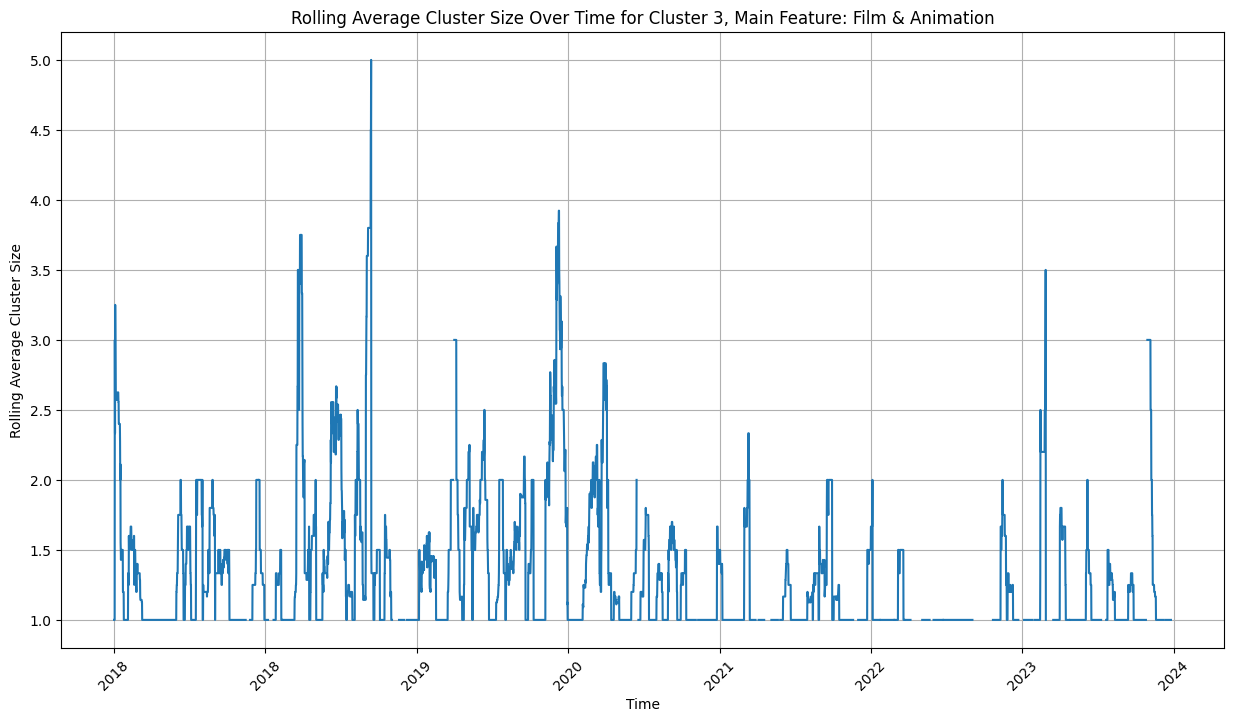

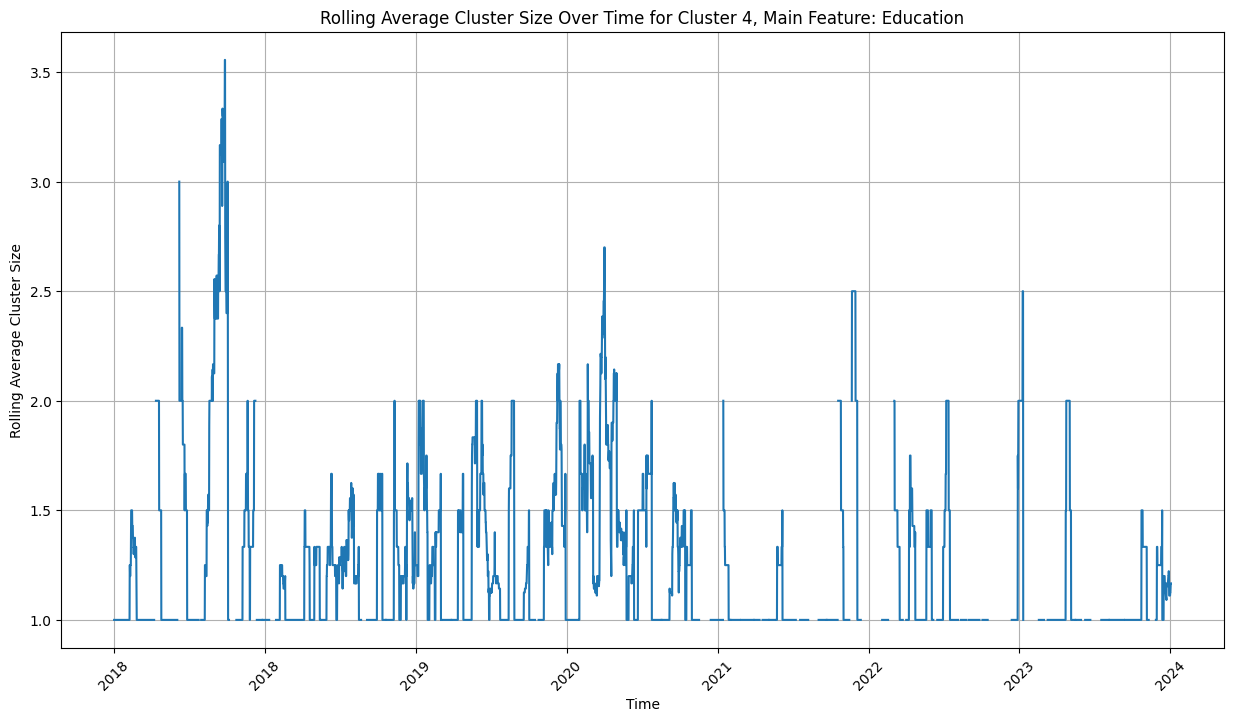

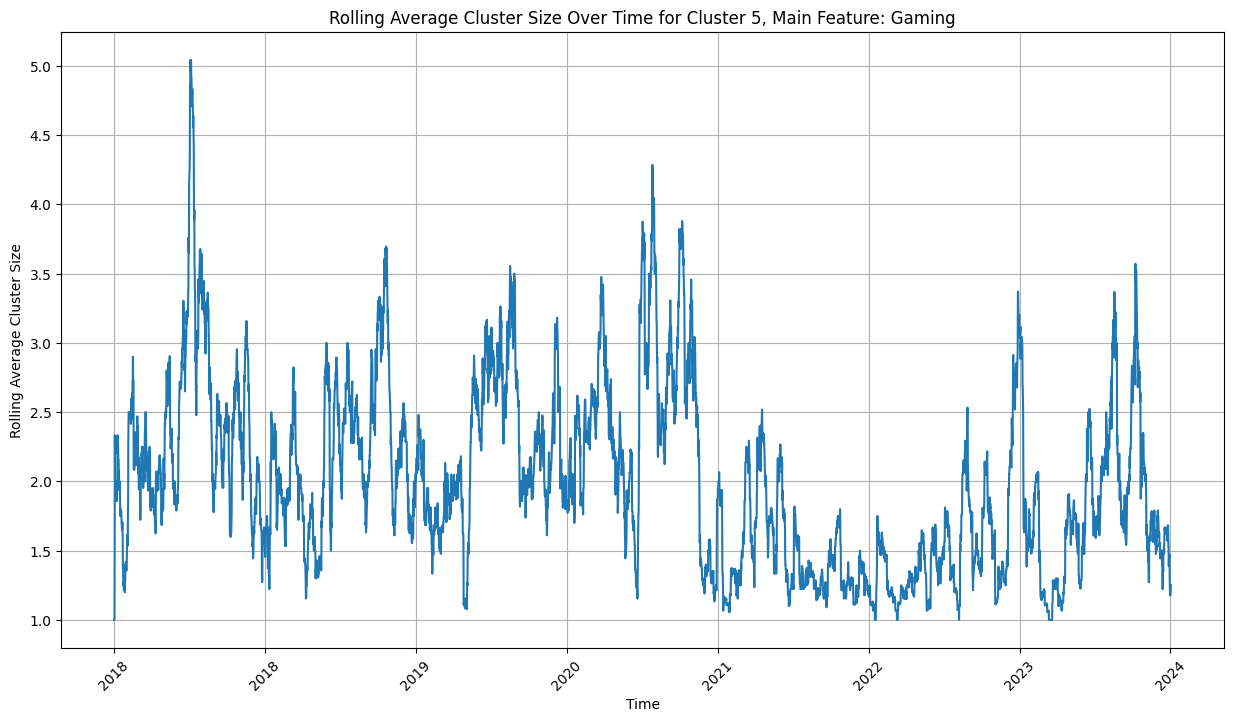

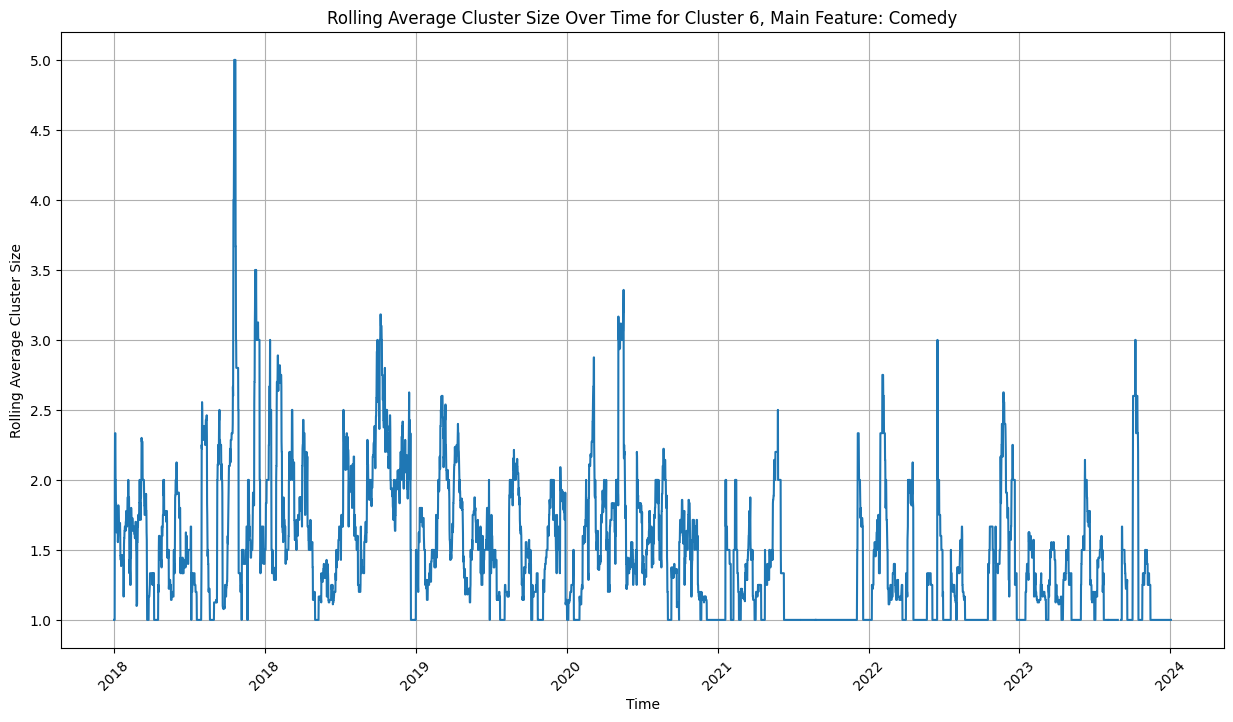

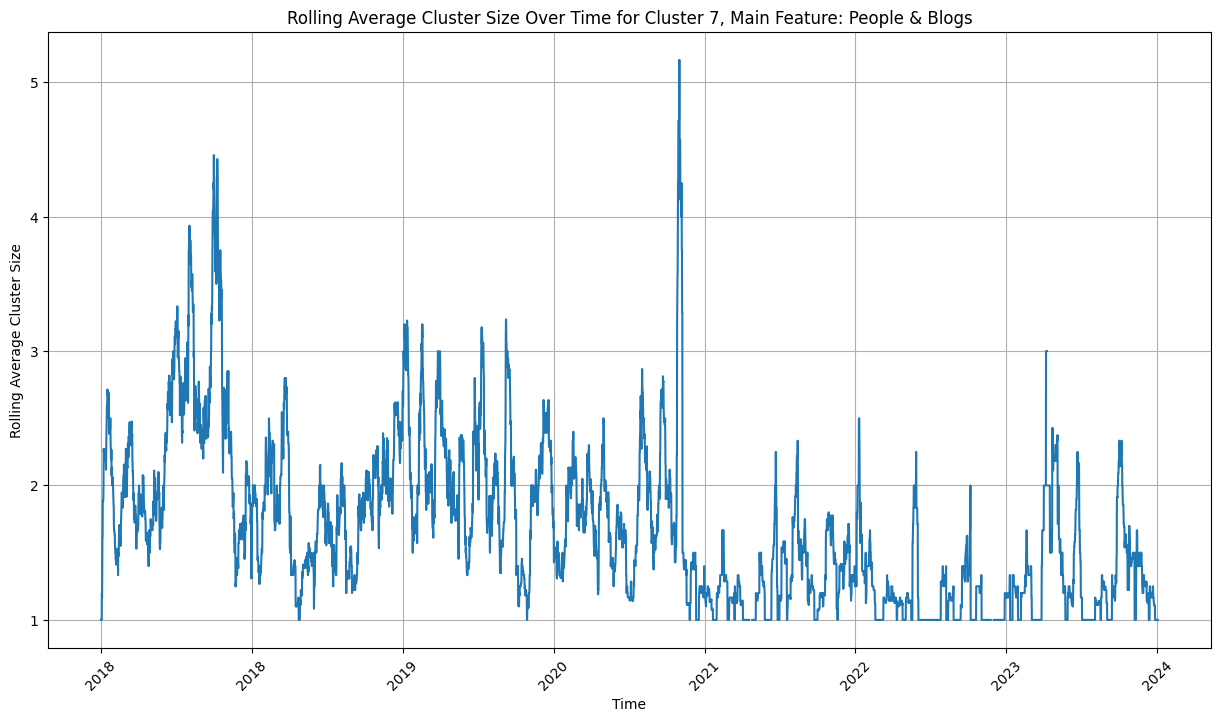

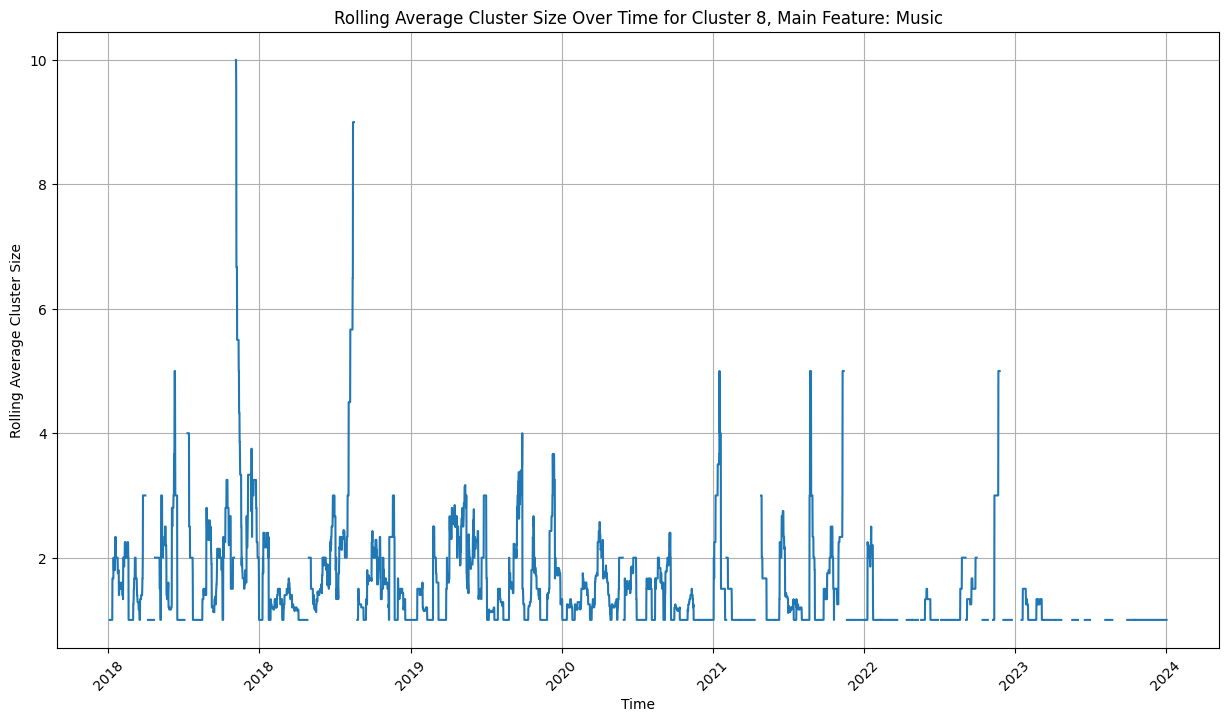

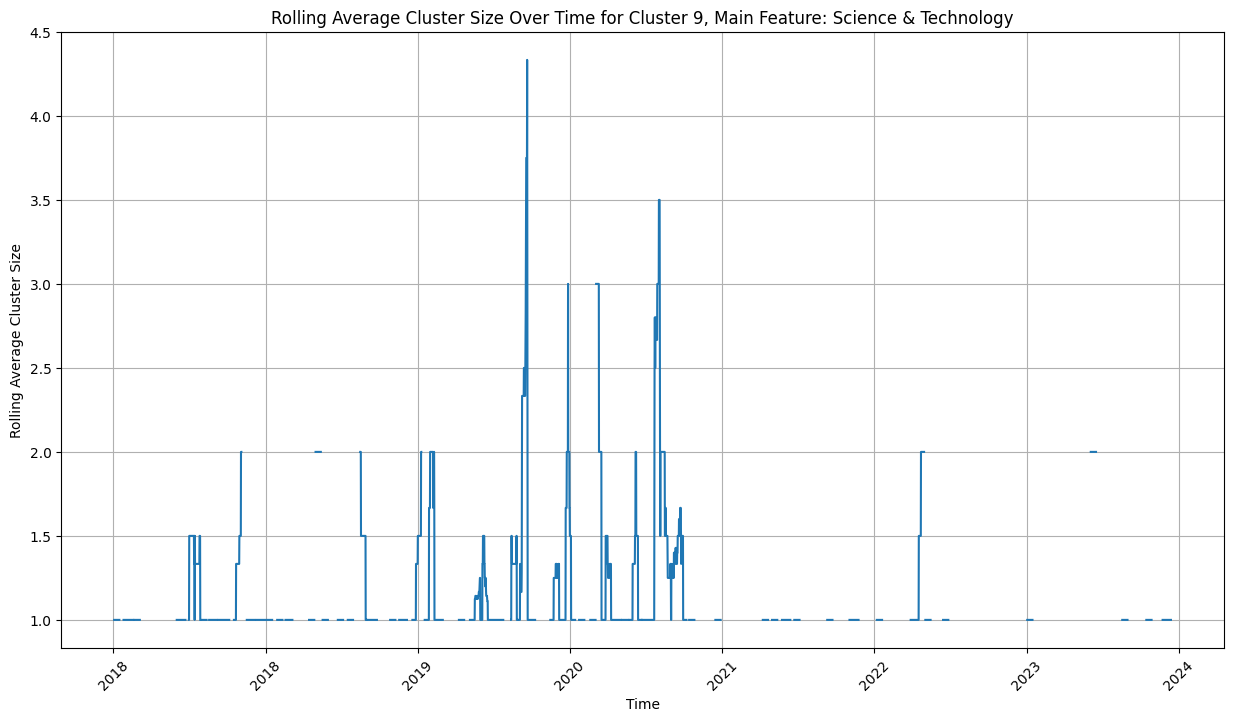

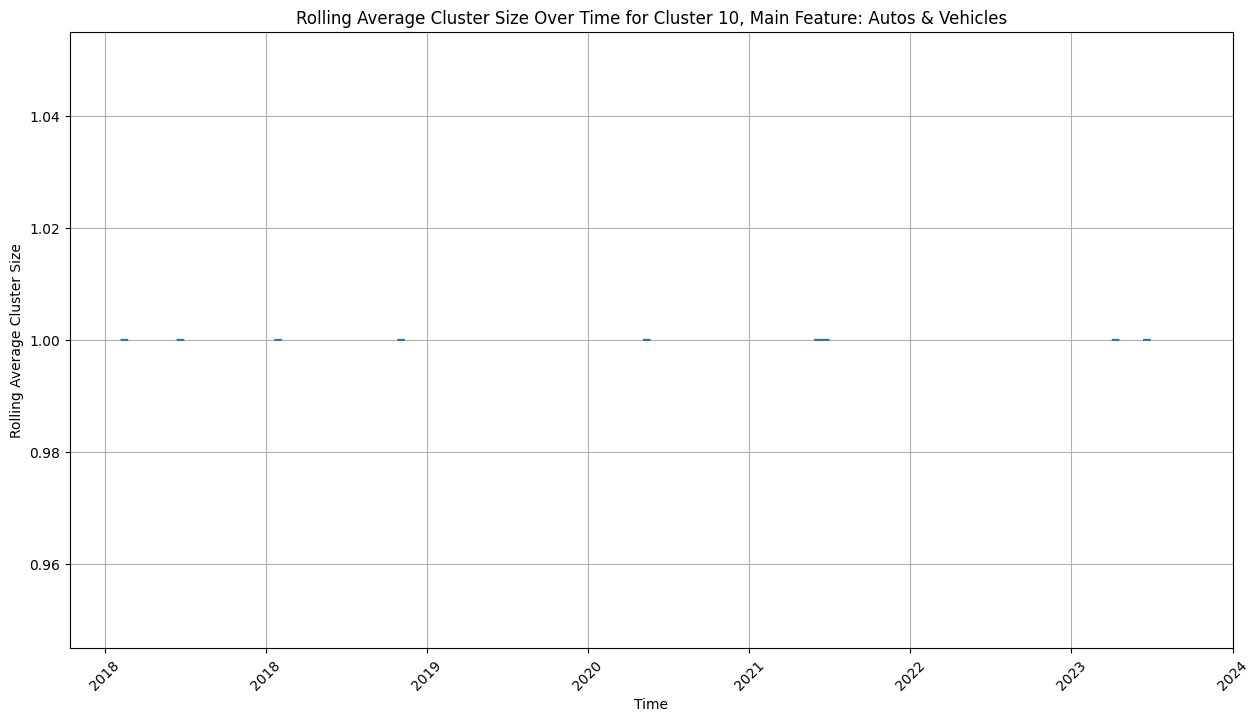

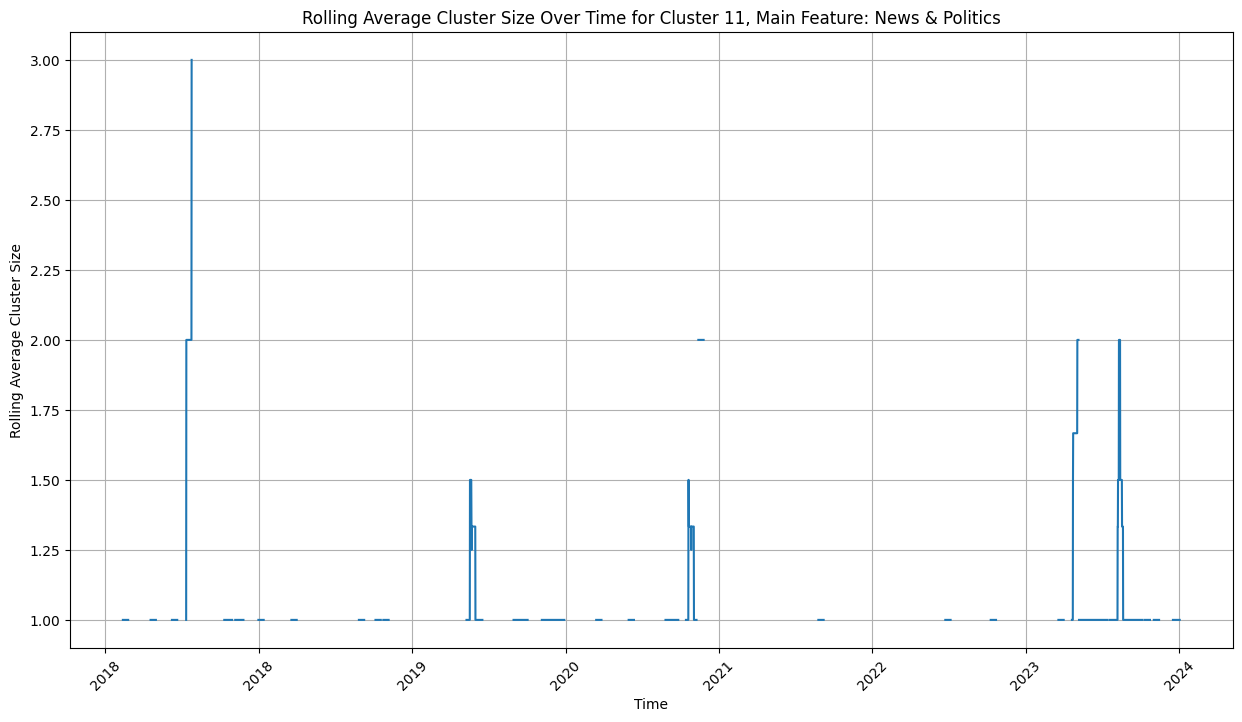

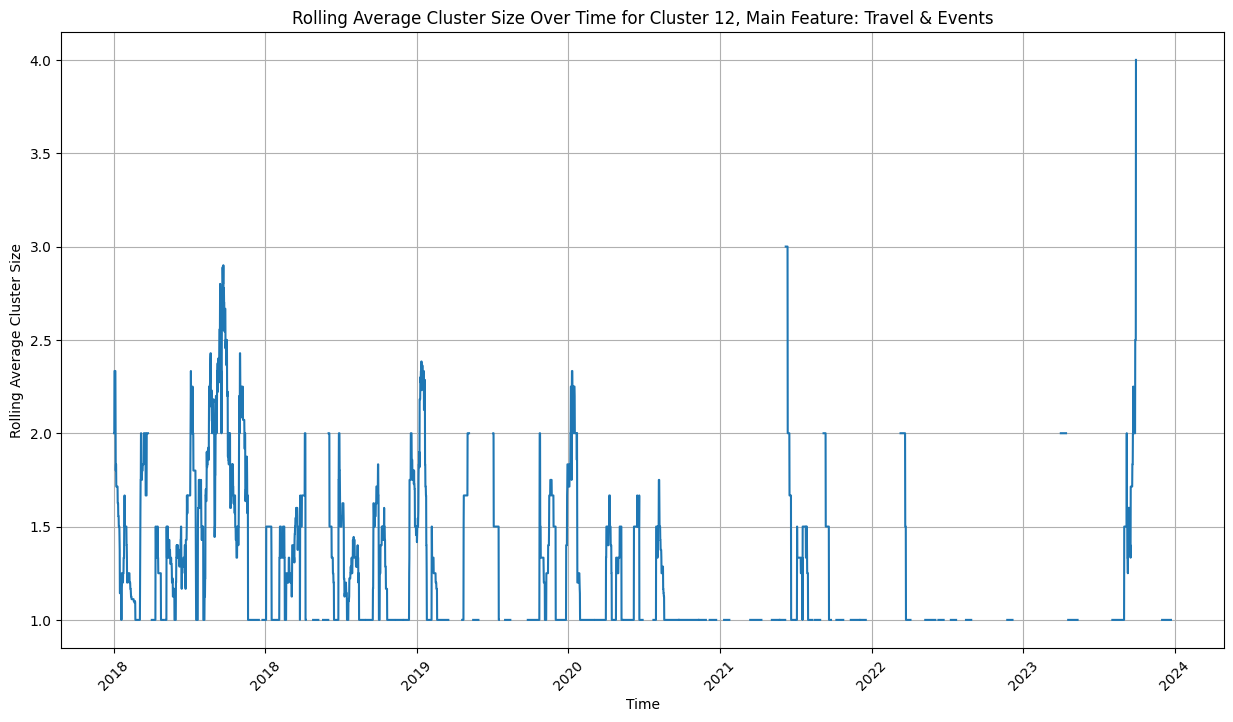

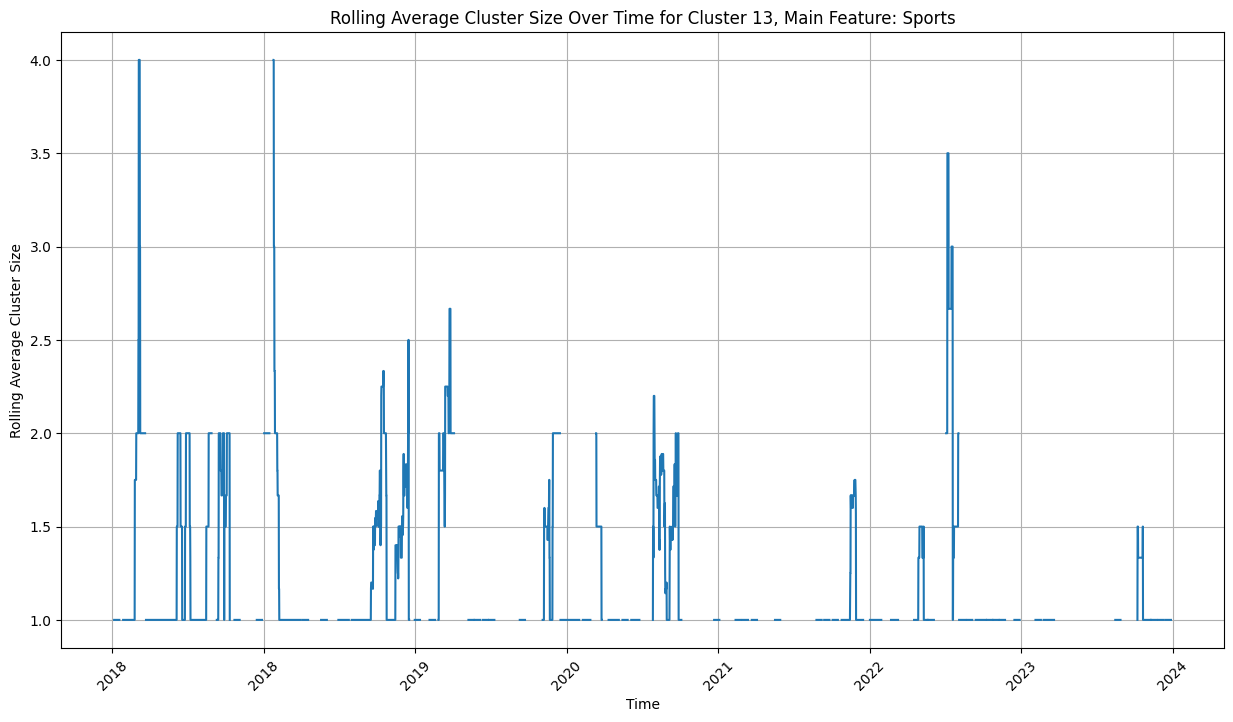

In [160]:
#Plot rolling mean of cluster sizes over time
cluster_size_rolling = features.groupby(["year", "month__sin", "month_cos", "day_sin", "day_cos", "hour_sin", "hour_cos", "Cluster"]).size().unstack().rolling(window=30, min_periods=1).mean()

clusters = cluster_size_rolling.columns
years = cluster_size_rolling.index.get_level_values("year")
#Used so our x-axis doesn't have a tick for each point
x_axis_spacing = int(len(cluster_size_rolling) / len(years.unique()))

#Create a plot for each cluster
for cluster in clusters:
    plt.figure(figsize=(15, 8))
    cluster_size_rolling[cluster].plot(kind="line")
    plt.title(f"Rolling Average Cluster Size Over Time for Cluster {cluster}, Main Feature: {cluster_mapping[cluster]}")
    plt.xlabel("Time")
    plt.ylabel("Rolling Average Cluster Size")
    plt.xticks(ticks=range(0, len(cluster_size_rolling), x_axis_spacing), labels=years[::x_axis_spacing], rotation=45)
    plt.grid(True)
    plt.show()


With each plot we can see the trends for each cluster. We can see where I tended to watch more of what kind of video as well as identify where I wasn't watching certain types. We calculated the rolling average based on a window size of 30 which provides a good combination of readability and detail. Where there are breaks in the line plot that indicates a lack of videos.


##**Insights & Conclusions**
We can draw our analysis using a combination of these line plots and the cluster plot from before. For example, when examining cluster 2 which is most closely associated with the entertainment category, you can notice a downwards trend as the years progress. On the other hand, cluster 5 that is associated with gaming, seems to experience peaks but overall the peak sizes seem to be more consistant which indicates that throughout the years, I've consistantly watched gaming content.

While I had a preconception of my watch habits, this analysis has served to uncover larger trends over time. For further expansion upon this analysis we can see if there are smaller trends in each cluster for likes or view counts. Additionally we could try and use the information we have gathered to create a recomendation system or prediction model.

This has served as an introduction into the data science pipeline. Through this exploration, I hope that we have all learned more about the process and that you feel confident in applying similar techniques to your own projects!